# Overview

In this workshop, we will perform data analysis and apply machine learning techniques to real-world clinical data.
A dataset was constructed based on the code provided in https://github.com/YerevaNN/mimic3-benchmarks
for the prediction of hospital mortality using early ICU admission data. 
 
The data were extracted from the MIMIC-III Clinical Database, which is a large, publicly-available database comprising de-identified electronic health records of approximately 60 000 ICU admissions. Patients stayed in the intensive care unit (ICU) of the Beth Israel Deaconess Medical Center between 2001 and 2012. MIMIC-III database is described in:

> Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, Mark RG. MIMIC-III, a freely accessible critical care database. Scientific Data (2016).

The tutorial is divided in two main parts:

* **Patient stratification** through **unsupervised learning**
    * Time series trends partitioned by outcome
    * k-means clustering

* **Patient classification** through **supervised learning**
    * Feature selection
    * Logistic regression
    * Decision trees
    * Random forest

# 1. Import modules and data

We will use the unique ICU stay ID as the dataframe index.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.style.use('ggplot')

data = pd.read_csv('/Users/catiasalgado/dataset.csv',index_col='icustay')

/Users/catiasalgado/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 2. Data exploration

In [4]:
display.display(data.head())
print()

diastolic BP  glasgow coma scale  glucose  heart rate     hours  \
icustay                                                                     
282372.0          60.0                 NaN      NaN       139.0  0.066667   
282372.0          73.0                 NaN      NaN       128.0  0.150000   
282372.0          81.0                 NaN      NaN       127.0  0.233333   
282372.0          86.0                 NaN      NaN       132.0  0.316667   
282372.0          86.0                 NaN      NaN       138.0  0.400000   

             mean BP  oxygen saturation  respiratory rate  systolic BP  \
icustay                                                                  
282372.0   84.666702              100.0              20.0        134.0   
282372.0   93.000000              100.0              25.0        133.0   
282372.0   88.666702              100.0              22.0        104.0   
282372.0  100.000000              100.0              19.0        128.0   
282372.0  100.333000              100.0              21.0        129.0   

          temperature        age  gender  height  mortality  pH  weight  day  
icustay                                                                       
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1  
282372.0          NaN  48.682393     2.0     NaN          1 NaN    59.0    1

The dataset contains information regarding:

* Patient demographics
    * age
    * gender
    * weight
    * height
    * mortality
    
* Physiological vital signs
    * diastolic blood pressure
    * systolic blood pressure
    * mean blood pressure
    * temperature
    * respiratory rate
    
* Lab Tests
    * Chemistry 
        * glucose
    * Arterial blood gases (ABGs)
        * pH

* Scores
    * glasgow coma scale
    
Each measurement is associated with a time stamp (column 'hours'), indicating the number of hours since ICU admission where the measurement was taken.
    
Now lets see some summary statistics.

In [5]:
print('Number of ICU stays: ' + str(len(data.index.unique())))
df = data.groupby(['icustay']).mean()
print('Number of survivors: ' + str(df[df['mortality'] == 0].count()['mortality']))
print('Number of non-survivors: ' + str(df[df['mortality'] == 1].count()['mortality']))
print('Mortality: ' + str(round(100*df[df['mortality'] == 1].sum()['mortality'] / len(data.index.unique()),1)) + '%')
print()
display.display(data.info(null_counts=1))
display.display(data.describe())

Number of ICU stays: 21140
Number of survivors: 18342
Number of non-survivors: 2797
Mortality: 13.2%

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1730668 entries, 282372.0 to nan
Data columns (total 17 columns):
diastolic BP          1195941 non-null float64
glasgow coma scale    187570 non-null float64
glucose               293604 non-null float64
heart rate            1255963 non-null float64
hours                 1730668 non-null float64
mean BP               1187689 non-null float64
oxygen saturation     1265732 non-null float64
respiratory rate      1266816 non-null float64
systolic BP           1196430 non-null float64
temperature           379653 non-null float64
age                   1461282 non-null float64
gender                1461282 non-null float64
height                455361 non-null float64
mortality             1730668 non-null int64
pH                    146147 non-null float64
weight                1309930 non-null float64
day                   1730668 non-n

None

diastolic BP  glasgow coma scale        glucose    heart rate  \
count  1.195941e+06       187570.000000  293604.000000  1.255963e+06   
mean   6.118764e+01           11.608514     147.421184  8.684657e+01   
std    2.477219e+02            3.914011    1846.627000  1.970154e+01   
min   -1.300000e+01            3.000000       0.000000  0.000000e+00   
25%    5.100000e+01            9.000000     106.000000  7.400000e+01   
50%    5.900000e+01           14.000000     129.000000  8.500000e+01   
75%    6.800000e+01           15.000000     162.000000  9.800000e+01   
max    1.141090e+05           15.000000  999999.000000  6.632000e+03   

              hours       mean BP  oxygen saturation  respiratory rate  \
count  1.730668e+06  1.187689e+06       1.265732e+06      1.266816e+06   
mean   2.188633e+01  7.850657e+01       9.759810e+01      2.104548e+01   
std    1.419493e+01  1.360455e+02       8.721160e+02      2.092837e+03   
min    0.000000e+00 -3.700000e+01       0.000000e+00      0.000000e+00   
25%    9.031389e+00  6.700000e+01       9.600000e+01      1.500000e+01   
50%    2.099778e+01  7.600000e+01       9.800000e+01      1.900000e+01   
75%    3.410000e+01  8.700000e+01       1.000000e+02      2.300000e+01   
max    4.800000e+01  1.171200e+05       9.810230e+05      2.355555e+06   

        systolic BP    temperature           age        gender         height  \
count  1.196430e+06  379653.000000  1.461282e+06  1.461282e+06  455361.000000   
mean   1.196717e+02      37.008739  6.535809e+01  1.554603e+00     169.170224   
std    2.840454e+01       8.913396  1.663225e+01  4.970097e-01      14.552301   
min    0.000000e+00      -3.000000  1.803403e+01  1.000000e+00       0.000000   
25%    1.030000e+02      36.444444  5.474257e+01  1.000000e+00     163.000000   
50%    1.170000e+02      37.000000  6.738069e+01  2.000000e+00     170.000000   
75%    1.340000e+02      37.555556  7.862746e+01  2.000000e+00     178.000000   
max    1.375600e+04    5336.111111  9.000000e+01  2.000000e+00     445.000000   

          mortality             pH        weight           day  
count  1.730668e+06  146147.000000  1.309930e+06  1.730668e+06  
mean   1.451474e-01       7.277576  8.280987e+01  1.441219e+00  
std    3.522495e-01       2.186084  2.575886e+01  4.965329e-01  
min    0.000000e+00       0.000000  0.000000e+00  1.000000e+00  
25%    0.000000e+00       7.310000  6.650000e+01  1.000000e+00  
50%    0.000000e+00       7.370000  7.910000e+01  1.000000e+00  
75%    0.000000e+00       7.420000  9.440000e+01  2.000000e+00  
max    1.000000e+00     733.000000  9.312244e+02  2.000000e+00

There are 21,140 unique ICU stays and 1,730,668 observations. 

All variables except 'hours', 'mortality' and 'day' have missing information.

Outliers can already be spotted (e.g. max glucose).

## 2.1. Variable selection

### 2.1.1. Aggregate data by ICU stay and look at the number of non-null values
This will give an indication of how many ICU stays have at least one measurement per variable.

In [6]:
print(data.groupby(['icustay']).mean().info(null_counts=1))

<class 'pandas.core.frame.DataFrame'>
Float64Index: 21139 entries, 200001.0 to 299995.0
Data columns (total 17 columns):
diastolic BP          19154 non-null float64
glasgow coma scale    10993 non-null float64
glucose               18745 non-null float64
heart rate            19282 non-null float64
hours                 21139 non-null float64
mean BP               19123 non-null float64
oxygen saturation     19305 non-null float64
respiratory rate      19367 non-null float64
systolic BP           19154 non-null float64
temperature           18440 non-null float64
age                   21139 non-null float64
gender                21139 non-null float64
height                5370 non-null float64
mortality             21139 non-null float64
pH                    15489 non-null float64
weight                18181 non-null float64
day                   21139 non-null float64
dtypes: float64(17)
memory usage: 2.9 MB
None


### 2.1.2. Select variables 

There should be a trade-off between the potential value of the variable in the model and the amount of data available. 

* Height can be discarded due to the high amount of missing data

* Weight and height are typically used combined (body mass index), therefore weight can also be discarded.

* The other variables we will keep. Let's start with time-variant variables and set aside age and gender for now.

In [7]:
variables = ['diastolic BP', 'glasgow coma scale',
             'glucose', 'heart rate', 'mean BP',
             'oxygen saturation', 'respiratory rate', 'systolic BP',
             'temperature', 'pH']
variables_mort = variables.copy()
variables_mort.append('mortality')

# 3. Data preprocessing
## 3.1. Outliers
### 3.1.1. Visualize data

We already saw that there are outliers in the data. Let's have a closer look at this.

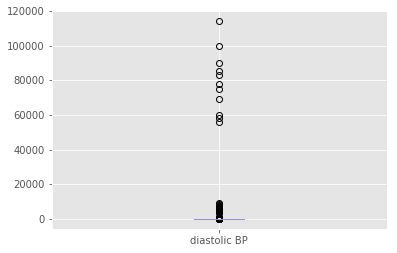

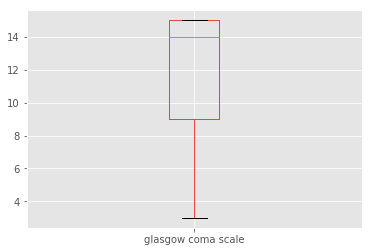

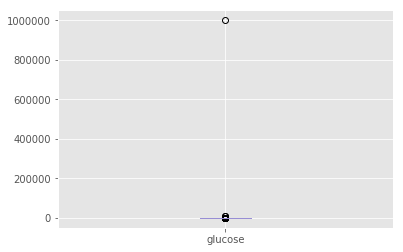

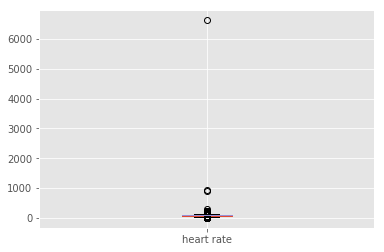

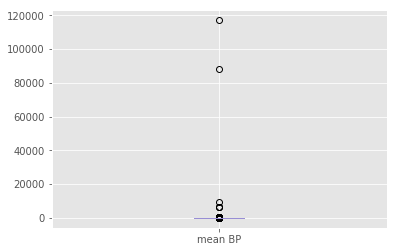

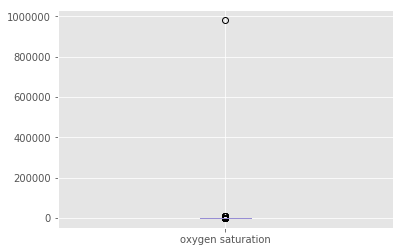

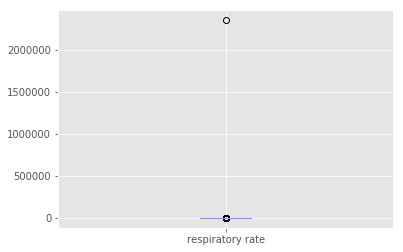

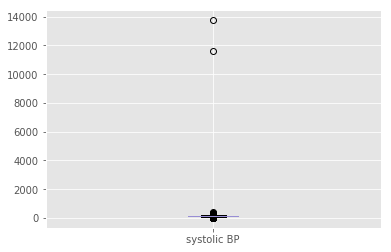

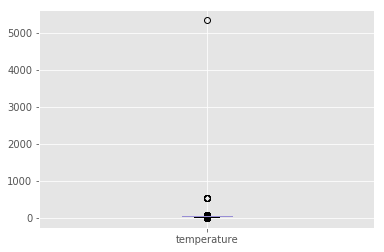

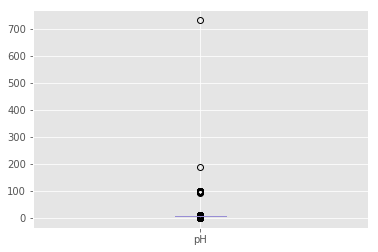

In [8]:
for variable in data[variables]:
    data[variable].plot.box()
    plt.show()

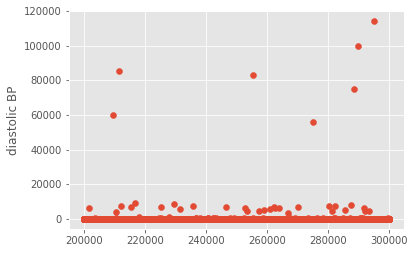

In [9]:
variable = 'diastolic BP'
plt.scatter(data.index, data[variable])
plt.ylabel(variable)
plt.show()

### 3.1.2. Choose method to deal with outliers

Ideally, we should keep extreme values related to the poor health condition of patients, and discard impossible values (such as negative temperature) and probable outliers (such as heart rate above 250 beats/min). In order to do so, we will remove values that fall outside boudaries defined by expert knowledge. This will avoid discarding extreme (but correct/possible) values.


In [10]:
nulls_before = data.isnull().sum().sum()

data.loc[data['diastolic BP']>300, 'diastolic BP'] = np.nan
data.loc[data['glucose']>2000, 'glucose'] = np.nan
data.loc[data['heart rate']>400, 'heart rate'] = np.nan
data.loc[data['mean BP']>300, 'mean BP'] = np.nan
data.loc[data['mean BP']<0, 'mean BP'] = np.nan
data.loc[data['systolic BP']>10000,  'systolic BP'] = np.nan
data.loc[data['temperature']>50, 'temperature'] = np.nan
data.loc[data['temperature']<20, 'temperature'] = np.nan
data.loc[data['pH']>7.8, 'pH'] = np.nan
data.loc[data['pH']<6.8, 'pH'] = np.nan
data.loc[data['respiratory rate']>300, 'respiratory rate'] = np.nan
data.loc[data['oxygen saturation']>100, 'oxygen saturation'] = np.nan
data.loc[data['oxygen saturation']<0, 'oxygen saturation'] = np.nan

nulls_now = data.isnull().sum().sum()
print('Number of outliers removed: ' + str(nulls_now - nulls_before))


Number of outliers removed: 9213


### 3.1.3. Visualize data after outliers removal

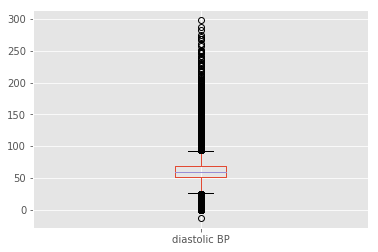

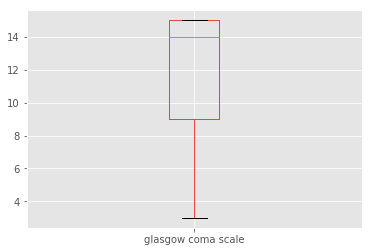

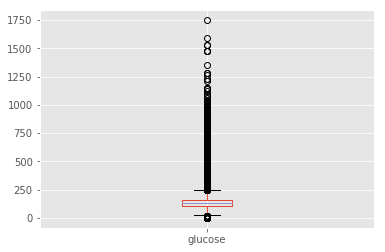

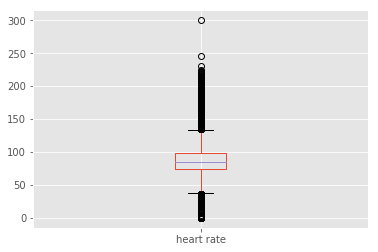

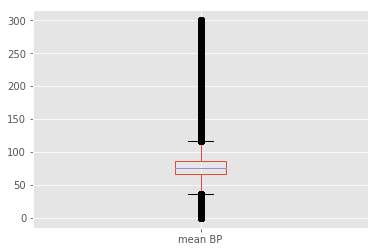

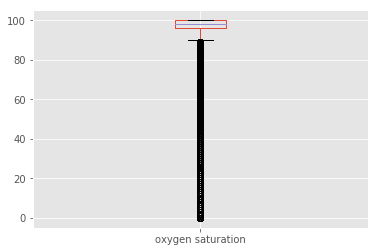

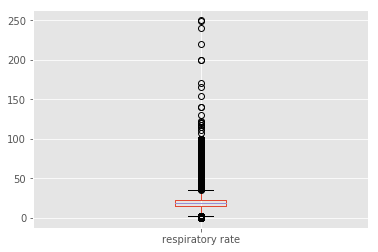

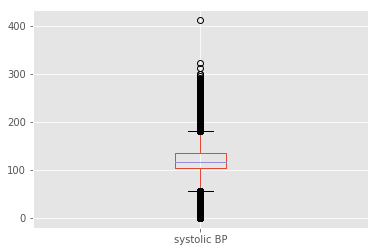

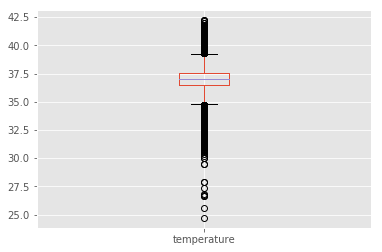

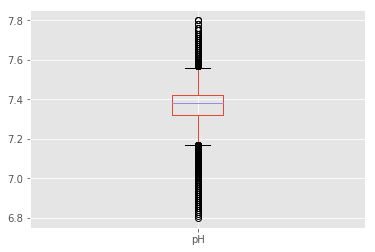

In [11]:
for variable in data[variables]:
    data[variable].plot.box()
    plt.show()

## 3.2. Aggregate data by hour

To allow for ease of comparison, individual data is condensed into hourly measurements by selecting the median value of the available measurements within each hour.

In [12]:
data['hour'] = data['hours'].apply(np.floor)
# data goes until h = 48
data.loc[data['hour'] == 48, 'hour'] = 47
data_median_hour = data.groupby(['icustay','hour'])[variables_mort].median()
# dataframe is multindex (icustay and hour)

# go back to icustay index
icustays = data_median_hour.index.get_level_values(0)
data_median_hour['hour'] = data_median_hour.index.get_level_values(1)
data_median_hour = data_median_hour.set_index(icustays)
data_median_hour= data_median_hour[['hour', 'diastolic BP', 'glasgow coma scale', 'glucose', 'heart rate',
       'mean BP', 'oxygen saturation', 'respiratory rate', 'systolic BP',
       'temperature', 'pH', 'mortality']]
display.display(data_median_hour.loc[299995.0])

hour  diastolic BP  glasgow coma scale  glucose  heart rate  \
icustay                                                                 
299995.0   1.0          51.0                 7.0      NaN       106.0   
299995.0   2.0          53.0                 7.0      NaN        90.0   
299995.0   3.0          66.0                 NaN      NaN        97.0   
299995.0   4.0          60.0                 9.0    124.0        94.0   
299995.0   5.0          59.0                 NaN      NaN        89.0   
299995.0   6.0          59.0                 8.0      NaN        89.0   
299995.0   7.0          65.0                 NaN      NaN        89.0   
299995.0   8.0          58.0                 9.0    112.0        90.0   
299995.0   9.0          61.0                 NaN      NaN        90.0   
299995.0  10.0          63.0                10.0      NaN        90.0   
299995.0  11.0          63.0                 NaN      NaN        89.0   
299995.0  12.0          53.0                10.0      NaN        84.0   
299995.0  13.0          61.0                 NaN      NaN        78.5   
299995.0  14.0          63.0                15.0      NaN        83.0   
299995.0  15.0          67.0                 NaN      NaN        88.0   
299995.0  16.0          67.0                15.0      NaN        97.0   
299995.0  17.0          67.0                 NaN      NaN        94.0   
299995.0  18.0          63.0                15.0      NaN        89.0   
299995.0  19.0           NaN                 NaN      NaN        92.0   
299995.0  20.0          69.0                15.0      NaN        88.0   
299995.0  21.0           NaN                 NaN      NaN        84.0   
299995.0  22.0          73.0                15.0      NaN        99.0   
299995.0  23.0           NaN                 NaN      NaN       100.0   
299995.0  24.0           NaN                15.0      NaN        99.0   
299995.0  25.0           NaN                 NaN      NaN        94.0   
299995.0  26.0          72.0                15.0      NaN        90.0   
299995.0  27.0          72.0                 NaN      NaN        94.0   
299995.0  28.0          59.0                15.0      NaN        95.0   
299995.0  29.0           NaN                 NaN      NaN        94.0   
299995.0  30.0          82.0                15.0      NaN        85.0   
299995.0  31.0           NaN                 NaN      NaN        89.0   
299995.0  32.0           NaN                 NaN      NaN        96.0   
299995.0  33.0           NaN                 NaN      NaN        82.0   
299995.0  34.0          65.0                 NaN      NaN        82.0   
299995.0  35.0           NaN                15.0      NaN        85.0   
299995.0  36.0           NaN                 NaN     85.0        88.0   
299995.0  37.0           NaN                 NaN      NaN        86.0   
299995.0  38.0          85.0                15.0      NaN        80.0   
299995.0  39.0           NaN                 NaN      NaN        78.0   
299995.0  40.0           NaN                 NaN      NaN        69.0   
299995.0  41.0           NaN                 NaN      NaN        66.0   
299995.0  42.0           NaN                15.0      NaN         NaN   
299995.0  43.0          82.0                 NaN      NaN        74.0   
299995.0  44.0           NaN                 NaN      NaN        72.0   
299995.0  45.0           NaN                 NaN      NaN        82.0   
299995.0  46.0          65.0                15.0      NaN        73.0   

          mean BP  oxygen saturation  respiratory rate  systolic BP  \
icustay                                                               
299995.0     65.0               94.0              35.5        111.0   
299995.0     71.0               98.0              27.0        127.0   
299995.0     89.0               99.0              24.0        150.0   
299995.0     80.0               98.0              25.0        133.0   
299995.0     76.0               99.0               4.0        121.0   
299995.0

## 3.3. Select minimum number of measurements

We already decided to keep all the time-variant variables in our dataset. That means we have to discard patients who don't have enough information in any of the variables. One possible approach is to say that we will use all patients who have at least one measurement per variable. But we will be more conservative and say that we want at least two measurements per variable in our dataset. 

In the following function, setting 'min_num_meas = 2' means that we are selecting ICU stays where each variable was recorded at least once at two different hours.

In [13]:
# Select stays where there are at least 'min_num_meas' measurements.
min_num_meas = 2

def extr_min_num_meas(data_median_hour, min_num_meas):
    data_count = data_median_hour.groupby(['icustay'])[variables_mort].count()
    #print(data_count.head())
    #print(data_count.describe())

    for col in data_count:
        data_count[col] = data_count[col].apply(lambda x: np.nan if x < min_num_meas else x)

    data_count = data_count.dropna(axis=0, how='any')
    print('Number of ICU stays: ' + str(data_count.shape[0]))
    print('Number of features: ' + str(data_count.shape[1]))
    unique_stays = data_count.index.unique()

    data_median_hour = data_median_hour.loc[unique_stays]
    
    return data_median_hour

data_median_hour = extr_min_num_meas(data_median_hour, min_num_meas)

Number of ICU stays: 6931
Number of features: 11


As you may notice, we started with a database of around 60,000 ICU stays, imported a fraction of those that satisfied some criteria, in a total of 21,140 ICU stays, and are now looking at 6,931 ICU stays.

# 4. Explore the preprocessed data
## 4.1. Multivariate ploting
Plot pairwise relationships in the dataset, grouped by outcomes.

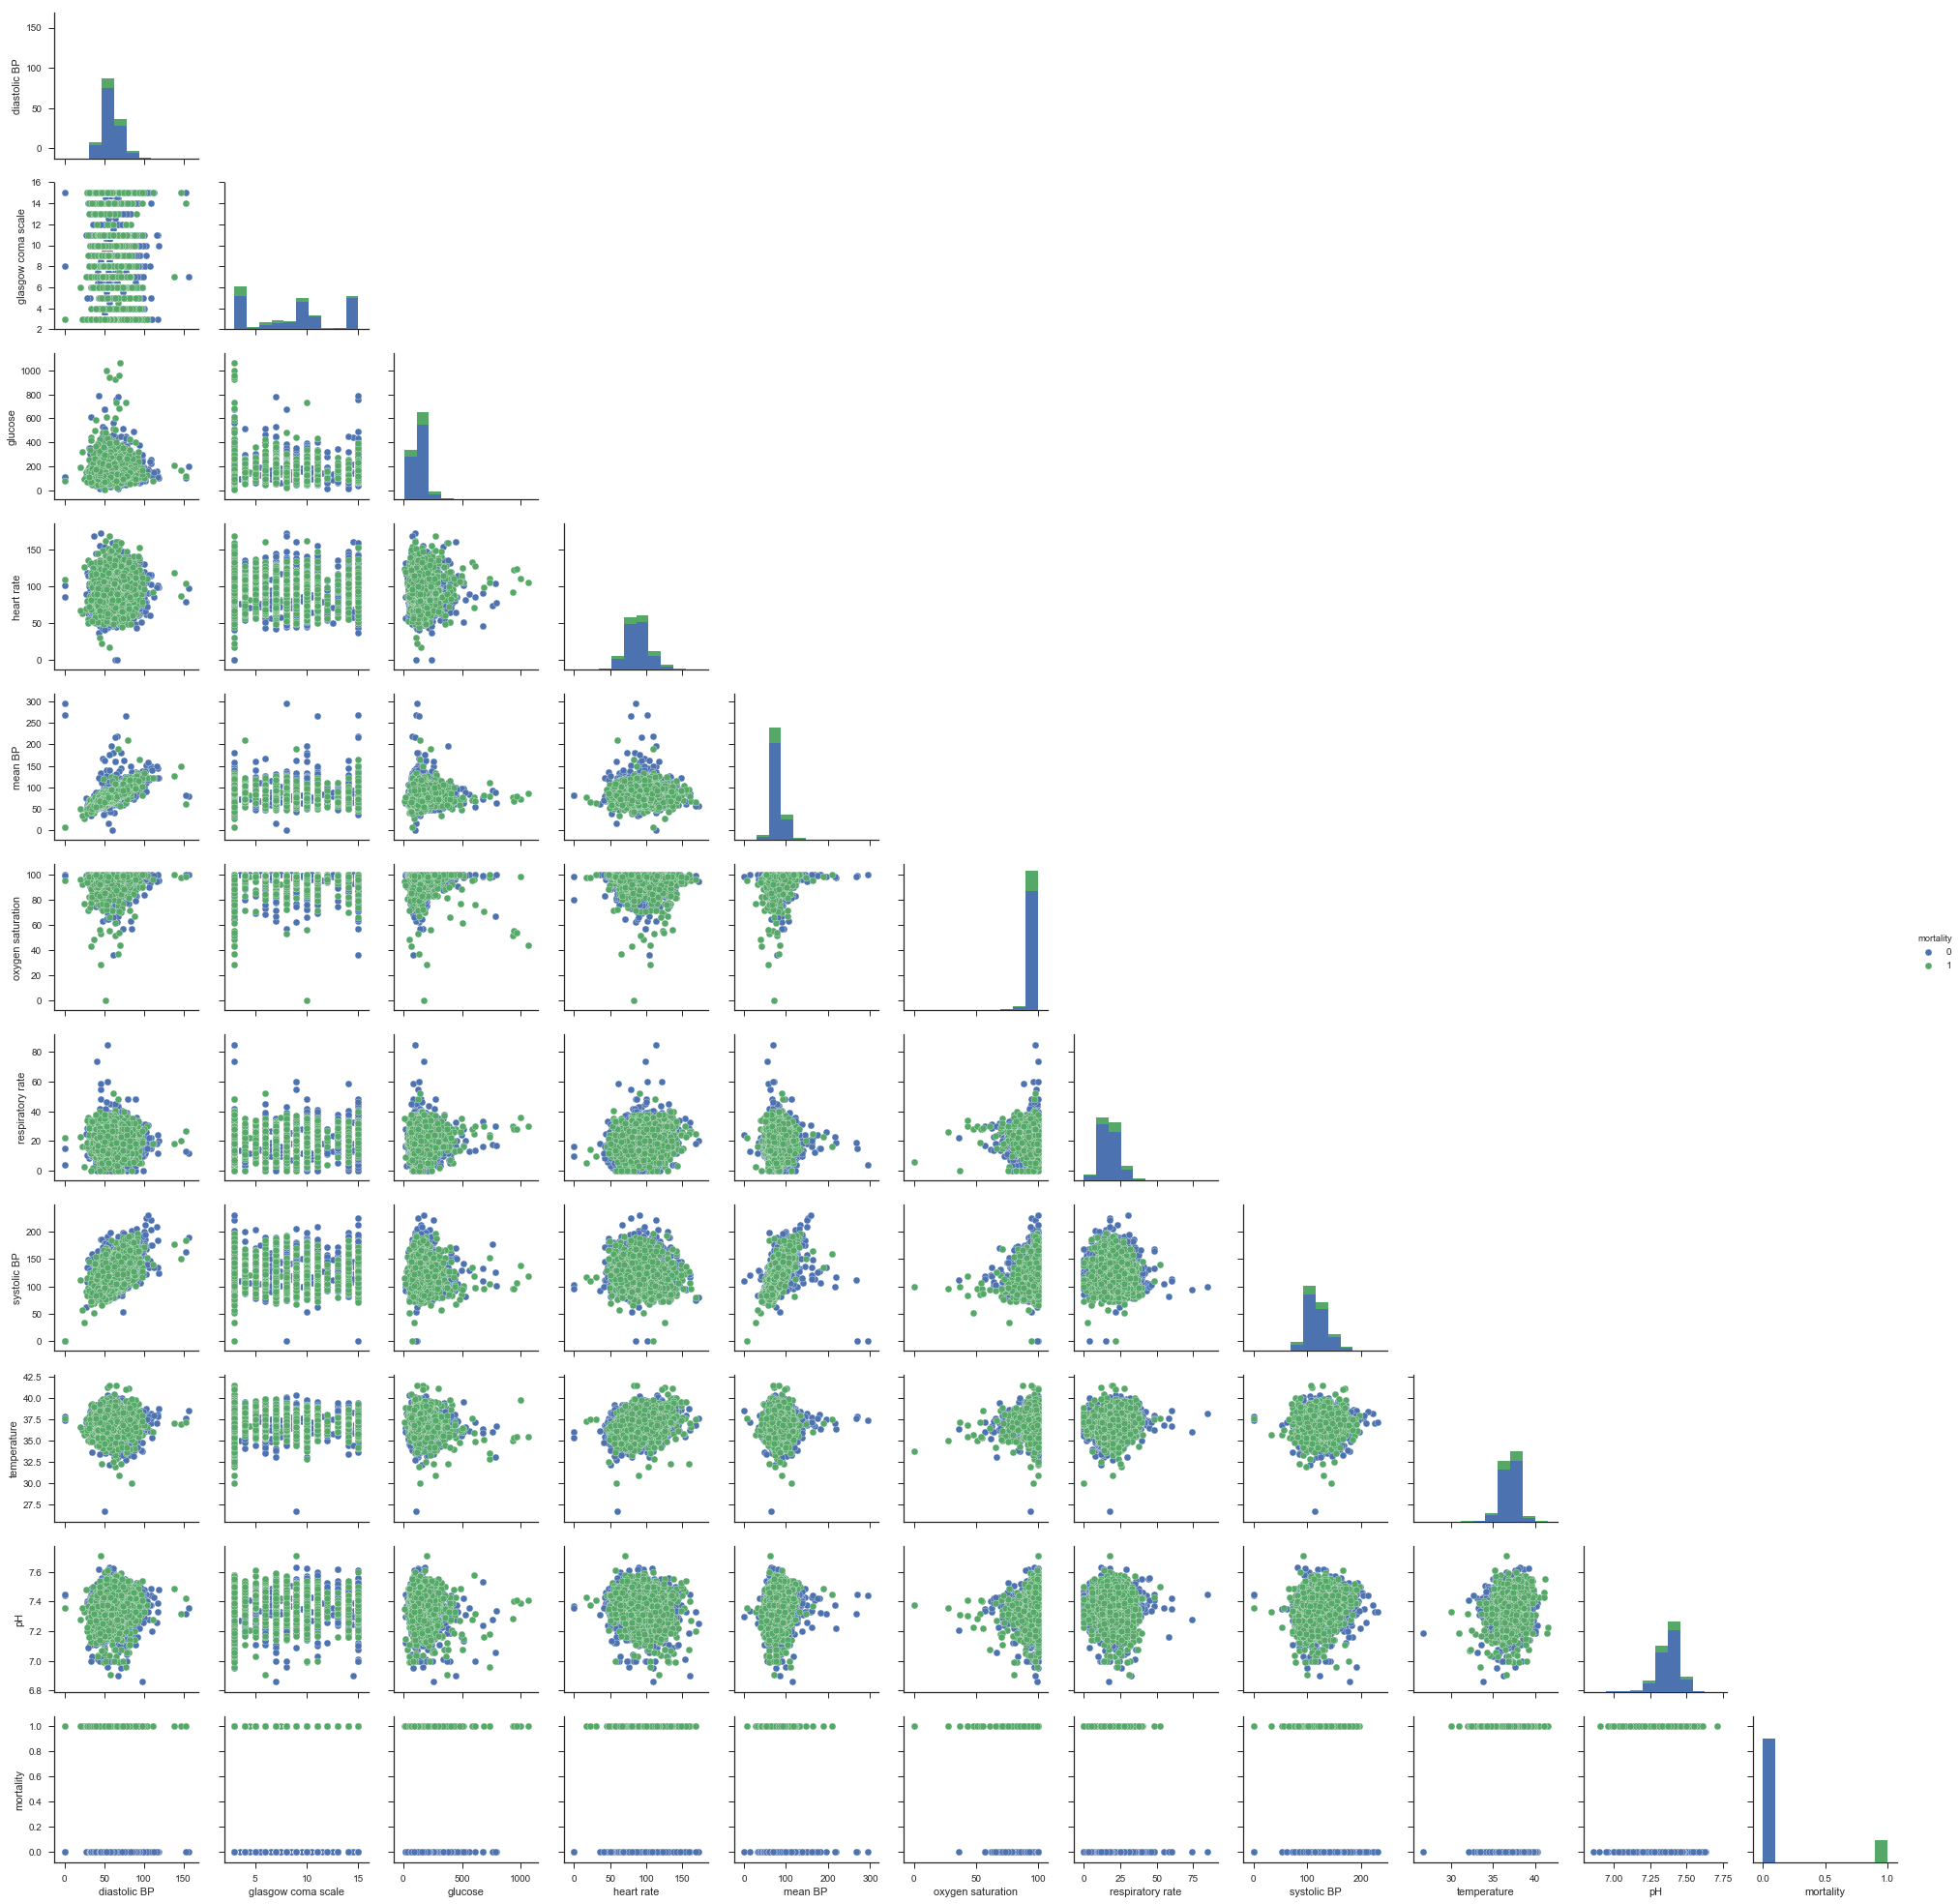

In [14]:
import seaborn as sns

sns.set(style="ticks")
g = sns.pairplot(data_median_hour[variables_mort].dropna(axis=0, how='any'), hue = 'mortality')

# hide the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
plt.show()

# change back to our preferred style
plt.style.use('ggplot')

Things to highlight:

* Hypoxic patients generally have lower SBPs
* SBP correlates with MAP, which is a nice test of the data's integrity
* Fever correlates with increasing tachycardia, as expected

## 4.2. Time series ploting

Here we investigate time trends partitioned by outcome.

### 4.2.1. Organize the dataset

In [15]:
def timeseries_data(data_median_hour, variable, filldata = 1):
    """Return matrix of time series data for clustering,
    with rows corresponding to unique observations (ICU stays) and 
    columns corresponding to time since ICU admission"""
    data4clustering = data_median_hour.pivot(columns='hour', values=variable)
    if filldata == 1:
        # first forward fill
        data4clustering = data4clustering.fillna(method='ffill', axis=1)
        # next backward fill
        data4clustering = data4clustering.fillna(method='bfill', axis=1)
        data4clustering = data4clustering.dropna(axis=0, how='all')
    return data4clustering

### 4.2.2. Plot mean values partitioned by outcome

Do not fill missing data at this point.

Plotting 308913 observations from 6931 ICU stays


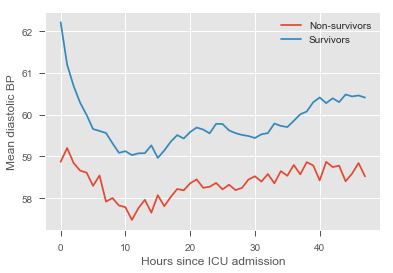

Plotting 107073 observations from 6931 ICU stays


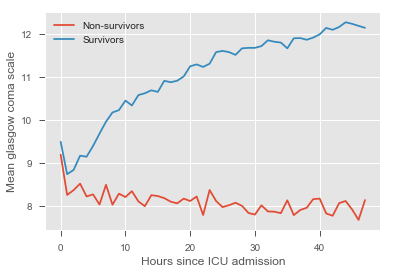

Plotting 99885 observations from 6931 ICU stays


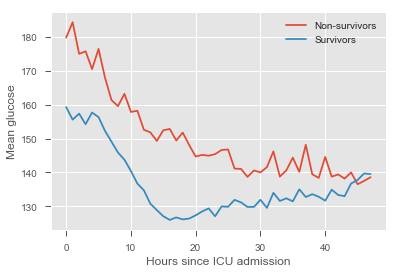

Plotting 310930 observations from 6931 ICU stays


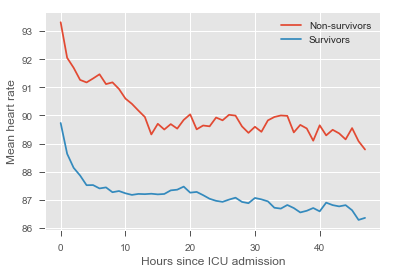

Plotting 306827 observations from 6931 ICU stays


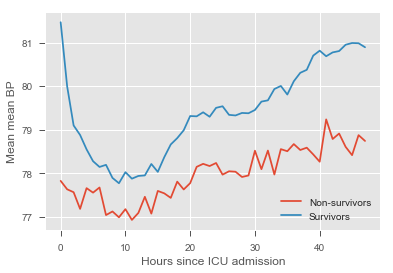

Plotting 302563 observations from 6931 ICU stays


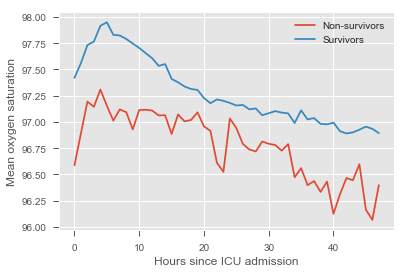

Plotting 305363 observations from 6931 ICU stays


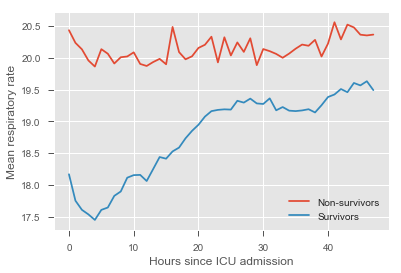

Plotting 308942 observations from 6931 ICU stays


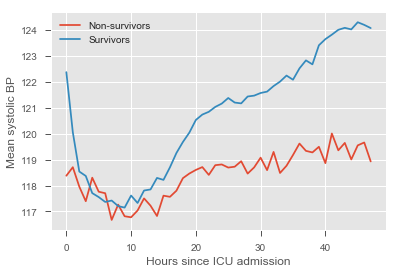

Plotting 138124 observations from 6931 ICU stays


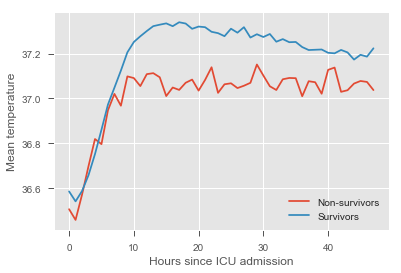

Plotting 60375 observations from 6931 ICU stays


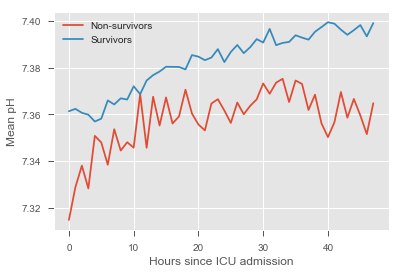

In [16]:
for variable in variables:
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 0)
    print('Plotting ' + str(data4clustering.count().sum()) + ' observations from ' + str(data4clustering.shape[0]) + ' ICU stays')
    mortality = data.loc[data4clustering.index]['mortality'].groupby(['icustay']).mean()
    data4clustering_mort = pd.concat([data4clustering, mortality], axis = 1)
    class1 = data4clustering_mort[data4clustering_mort['mortality']==1].drop(columns = ['mortality']).mean()
    class0 = data4clustering_mort[data4clustering_mort['mortality']==0].drop(columns = ['mortality']).mean()
    plt.figure()
    plt.plot(class1)
    plt.plot(class0)
    plt.xlabel('Hours since ICU admission')
    plt.ylabel('Mean ' + variable)
    plt.legend(['Non-survivors', 'Survivors'])
    plt.show()


We can see clear distinctions between the groups.

* **diastolic BP**
    * higher in the survival group
    * rapidly decreasing during the first 10 hours, especially in the survival group, and incresing at a lower rate thereafter
    
* **glasgow coma scale**
    * higher in the survival group, increasing over time
    * steady around 8 in the non-survival group
    * similar between both groups at admission, but diverging thereafter
    
* **glucose**
    * decreasing over time in both groups
    
* **heart rate**
    * lower in the survival group
    
* **mean BP** - similar to diastolic BP

* **oxygen saturation**
    * higher in the survival group
    * low variation from t=0 to t=48h
 
* **respiratory rate**
    * lower in the survival group, slowly increasing over time
    * steady around 20 in the non-survival group

* **systolic BP** - similar to diastolic and mean BP

* **temperature**
    * low variation from t=0 to t=48h
    * slightly increasing during the first 10 hours
    
* **pH**
    * Increasing over time in both groups
    * pH < 7.35 (associated with metabolic acidosis) during the first 10 hours in the non-survival group


Most of these graphs have fairly interesting trends, but we wouldn't consider the oxygen saturation or temperature graphs to be clinically significant.

    
# 5. Feature engineering
## 5.1. Feature construction

Feature construction addresses the problem of finding the transformation of variables containing the greatest amount of useful information. We will use simple operations to construct/extract important features from the time series:

* Maximum
* Minimum
* Standard deviation
* Mean

These features will summarize the worst, best, variation and average patient' condition from t=0 to t=48h, according to each variable. In the proposed exercises you will do this for each day separately, which will increase the dataset dimensionality but hopefully will allow the extraction of more useful information.

In [17]:
def feat_transf(data):
    data_max = data.groupby(['icustay'])[variables].max()
    data_max.columns = ['max ' + str(col) for col in data_max.columns]

    data_min = data.groupby(['icustay'])[variables].min()
    data_min.columns = ['min ' + str(col) for col in data_min.columns]
    
    data_sd = data.groupby(['icustay'])[variables].std()
    data_sd.columns = ['sd ' + str(col) for col in data_sd.columns]

    data_mean = data.groupby(['icustay'])[variables].mean()
    data_mean.columns = ['mean ' + str(col) for col in data_mean.columns]

    data_agg = pd.concat([data_min,data_max,data_sd,data_mean],axis=1)
    
    return data_agg

data_transf = feat_transf(data_median_hour)
print('Extracted features: ')
display.display(list(data_transf.columns))
print('')
print('Number of ICU stays: ' + str(data_transf.shape[0]))
print('Number of features: ' + str(data_transf.shape[1]))
display.display(data_transf.head())


Extracted features: 


['min diastolic BP',
 'min glasgow coma scale',
 'min glucose',
 'min heart rate',
 'min mean BP',
 'min oxygen saturation',
 'min respiratory rate',
 'min systolic BP',
 'min temperature',
 'min pH',
 'max diastolic BP',
 'max glasgow coma scale',
 'max glucose',
 'max heart rate',
 'max mean BP',
 'max oxygen saturation',
 'max respiratory rate',
 'max systolic BP',
 'max temperature',
 'max pH',
 'sd diastolic BP',
 'sd glasgow coma scale',
 'sd glucose',
 'sd heart rate',
 'sd mean BP',
 'sd oxygen saturation',
 'sd respiratory rate',
 'sd systolic BP',
 'sd temperature',
 'sd pH',
 'mean diastolic BP',
 'mean glasgow coma scale',
 'mean glucose',
 'mean heart rate',
 'mean mean BP',
 'mean oxygen saturation',
 'mean respiratory rate',
 'mean systolic BP',
 'mean temperature',
 'mean pH']


Number of ICU stays: 6931
Number of features: 40


min diastolic BP  min glasgow coma scale  min glucose  \
icustay                                                           
200003.0              47.0                     5.0         90.0   
200019.0              30.0                     6.0        117.0   
200045.0              16.0                     3.0         18.0   
200059.0              52.0                    10.0        121.0   
200102.0              35.5                     3.0        117.0   

          min heart rate  min mean BP  min oxygen saturation  \
icustay                                                        
200003.0            66.0    55.000000                   91.5   
200019.0            42.0    64.333298                   95.0   
200045.0            64.0    49.333302                   90.0   
200059.0            64.5    65.000000                   93.0   
200102.0            64.0    50.000000                   88.5   

          min respiratory rate  min systolic BP  min temperature  min pH  \
icustay                                                                    
200003.0                   0.0             82.0        36.388901    7.36   
200019.0                  11.0            129.0        36.166698    7.36   
200045.0                   2.0            104.0        36.111111    7.19   
200059.0                  10.5             89.0        33.055599    7.37   
200102.0                   4.0             84.0        35.300001    7.34   

            ...     mean diastolic BP  mean glasgow coma scale  mean glucose  \
icustay     ...                                                                
200003.0    ...             61.446809                10.538462    125.750000   
200019.0    ...             48.829545                 7.769231    139.300000   
200045.0    ...             47.958333                12.000000    171.714286   
200059.0    ...             68.712766                10.250000    166.062500   
200102.0    ...             51.000000                 7.227273    174.521739   

          mean heart rate  mean mean BP  mean oxygen saturation  \
icustay                                                           
200003.0        86.744681     75.138298               96.819149   
200019.0        54.922222     88.499998               99.255556   
200045.0        87.083333     75.645842               97.512195   
200059.0        93.728261     91.553191               99.788889   
200102.0        78.156250     69.458333               95.437500   

          mean respiratory rate  mean systolic BP  mean temperature   mean pH  
icustay                                                                        
200003.0              23.130435        104.159574         37.491236  7.419444  
200019.0              20.122222        167.909091         37.310201  7.370000  
200045.0              21.936170        130.062500         36.663600  7.281429  
200059.0              14.776596        131.861702         36.375740  7.413333  
200102.0              18.687500        115.156250         36.085660  7.382222  

[5 rows x 40 columns]

We just obtained a matrix containing one row per ICU stay. We are one step closer to building our models. Great!

Note that if we were to put all time series values together without performing this step, we would have $48 \text{hours}\times 11 \text{variables}=528$ features.

## 5.2. Add time invariant data

We can now add the time invariant information to our dataset.

In [18]:
mortality = data.loc[data_transf.index]['mortality'].groupby(['icustay']).mean()
age = data.loc[data_transf.index]['age'].groupby(['icustay']).mean()
# weight = data.loc[data_transf.index]['weight'].groupby(['icustay']).mean()
gender = data.loc[data_transf.index]['gender'].groupby(['icustay']).mean()

data_transf_inv = pd.concat([data_transf, age, gender, mortality], axis=1).dropna(axis=0)
print('Number of ICU stays: ' + str(data_transf_inv.shape[0]))
print('Number of features: ' + str(data_transf_inv.shape[1]))

Number of ICU stays: 6931
Number of features: 43


# 6. Data partitioning

We usually define:
* Training set: used to train/build the learning algorithm.
* Validation (or development) set: use to tune parameters, select features, and make other decisions regarding the learning algorithm. 
* Test set: used to evaluate the performance of the algorithm, but not to make any decisions regarding what learning algorithm or parameters to use.

For simplicity, we will divide the data into two sets, one for training and another for testing. We will use the train_test_split function from sklearn, which randomly assigns observations to each set. Later, when performing feature selection, we will partition the training set into two sets, for training and validating the models.

In [19]:
from sklearn.cross_validation import train_test_split

def data_partioning(data_transf_inv, test_size, perc_class1, print_):
    """Divide the data into training and test sets. 
    Use test_size to select the % of observations in the test set.
    If perc_class1 is given, undersampling is performed in order to have a balanced training set. 
    Use print_ = 1 to print the number of observations and class distribution in each set."""

    X_train, X_test, y_train, y_test = train_test_split(data_transf_inv, data_transf_inv[['mortality']], test_size = test_size, random_state = 10)
    if print_ == 1:
        if perc_class1 > 0:
            print('Before balancing')
        print(str(len(y_train[y_train['mortality']==1])) + '(' + str(round(len(y_train[y_train['mortality']==1])/len(y_train)*100,2)) + '%)' + ' non-survivors in training set')
        print(str(len(y_train[y_train['mortality']==0])) + '(' + str(round(len(y_train[y_train['mortality']==0])/len(y_train)*100,2)) + '%)' + ' survivors in training set')
        print(str(len(y_test[y_test['mortality']==1])) + '(' + str(round(len(y_test[y_test['mortality']==1])/len(y_test)*100,2)) + '%)' + ' non-survivors in test set')
        print(str(len(y_test[y_test['mortality']==0])) + '(' + str(round(len(y_test[y_test['mortality']==0])/len(y_test)*100,2)) + '%)' + ' survivors in test set')
        print()
        
    # Apply the random under-sampling
    class0_indices = y_train[y_train['mortality'] == 0].index
    class1_indices = y_train[y_train['mortality'] == 1].index
    if perc_class1 > 0:
        class0_size = round(np.int((len(y_train[y_train['mortality'] == 1])*(1 - perc_class1)) / perc_class1),0)
    
        # for reproducibility set the random seed generator
        np.random.seed(10)
        random_indices = np.random.choice(class0_indices, class0_size, replace=False)
        
        X_train_0 = X_train.loc[random_indices]
        y_train_0 = y_train.loc[random_indices]
        X_train_1 = X_train.loc[class1_indices]
        y_train_1 = y_train.loc[class1_indices]
        X_train = pd.concat([X_train_0,X_train_1])
        y_train = pd.concat([y_train_0,y_train_1])

        if print_ == 1:
            print()
            print('After balancing')
            print(str(len(y_train[y_train['mortality']==1])) + '(' + str(round(len(y_train[y_train['mortality']==1])/len(y_train)*100,2)) + '%)' + ' non-survivors in training set')
            print(str(len(y_train[y_train['mortality']==0])) + '(' + str(round(len(y_train[y_train['mortality']==0])/len(y_train)*100,2)) + '%)' + ' survivors in training set')
            print(str(len(y_test[y_test['mortality']==1])) + '(' + str(round(len(y_test[y_test['mortality']==1])/len(y_test)*100,2)) + '%)' + ' non-survivors in test set')
            print(str(len(y_test[y_test['mortality']==0])) + '(' + str(round(len(y_test[y_test['mortality']==0])/len(y_test)*100,2)) + '%)' + ' survivors in test set')
            print()

    X_train = X_train.drop(columns = 'mortality')
    X_test = X_test.drop(columns = 'mortality')
    
    return X_train, X_test, y_train, y_test

/Users/catiasalgado/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Select the test size (test_size) and percentage of class 1 samples (perc_class1) to be present in the training set. If perc_class1 is given, undersampling is performed in order to have a balanced training set. 

In [20]:
# select the test size and percentage of class 1 samples to be present in the training set
perc_class1 = 0.4
test_size = 0.2
print_ = 1

X_train, X_test, y_train, y_test = data_partioning(data_transf_inv, test_size, perc_class1, print_)

Before balancing
941(16.97%) non-survivors in training set
4603(83.03%) survivors in training set
246(17.74%) non-survivors in test set
1141(82.26%) survivors in test set


After balancing
941(40.01%) non-survivors in training set
1411(59.99%) survivors in training set
246(17.74%) non-survivors in test set
1141(82.26%) survivors in test set



# 7. Clustering

Clustering is a learning task that aims at decomposing a given set of observations into subgroups (clusters), based on data similarity, such that observations in the same cluster are more closely related to each other than observations in different clusters. It is an unsupervised learning task, since it identifies structures in unlabeled datasets, and a classification task, since it can give a label to observations according to the cluster they are assigned to.

In this workshop we focus on the questions:

* Can we identify distinct patterns even if the class labels are not provided? 

* How are the different patterns represented across different outcomes?

7.1. K-means clustering algorithm

7.2. Exemplification with 2D data

7.3. Time series clustering 

7.4. Normalize data

7.5. Concatenate predicted clustering labels with input data

## 7.1. K-means clustering algorithm

Consider a (training) dataset composed of $N$ observations:

$$
\begin{aligned}
x_1, x_2,..., x_N
\end{aligned}
$$

Initialize K centroids $\mu_1, \mu_2, ..., \mu_K$ randomly.

Repeat until convergence:

1. Cluster assignment <br>

    Assign each $x_i$ to the nearest cluster.<br>
    For every $i$ do: <br>
$$
\begin{aligned}
\underset{j}{argmin}\left \| x_i-\mu_j \right \|^2,
\end{aligned}
$$
    where $j=1,2,...,K$

2. Cluster updating <br>

    Update the cluster centroids $\mu_j$.<br>
    For every $j$ do:
$$
\begin{aligned}
\mu_j = \frac{1}{N_j}\left [ x_1^j + x_2^j + ... + x_{N_j}^j \right ],
\end{aligned}
$$
    where $N_j$ is the number of observations assigned to cluster $j$, $k=1,2, ..., N_j$, and $x_k^j$ represents observation $k$ assigned to cluster $j$. <br>
    Each new centroid corresponds the mean of the observations assigned in the previous step.

## 7.2. Exemplification with 2D data

We did not see groups in pairwise plots, but some groups might have emerged after the data were transformed. 

You can re-run the code for pairwise plots between transformed features, but it will be time consuming due to the high dimensionality of the dataset. 

As an example, we will look at max mean BP and mean heart rate.


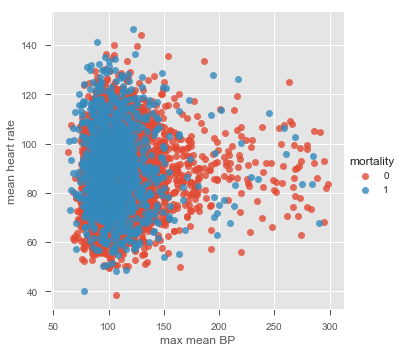

In [21]:
x1 = 'max mean BP'
x2 = 'mean heart rate'
sns.lmplot(x1, x2, data_transf_inv, hue="mortality", fit_reg=False);

The algorithm is implemented next. The number of clusters (K) must be provided. Here I chose 3.

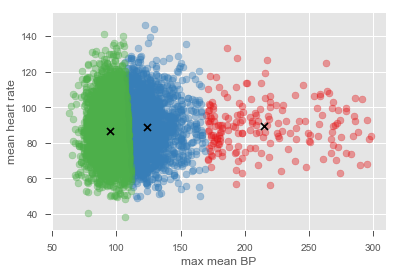

In [22]:
# The following code was adapted from http://jonchar.net/notebooks/k-means/

from sklearn.cluster import KMeans
import time
from IPython import display

K = 3
ground_truth = 'mortality'
X = pd.DataFrame.as_matrix(data_transf_inv[[x1,x2]])
mort = pd.DataFrame.as_matrix(data_transf_inv[ground_truth])

def initialize_clusters(points, k):
    """Initializes clusters as k randomly selected points from points."""
    return points[np.random.randint(points.shape[0], size=k)]
    
# Function for calculating the distance between centroids
def get_distances(centroid, points):
    """Returns the distance the centroid is from each data point in points."""
    return np.linalg.norm(points - centroid, axis=1)

# Initialize our centroids by picking random data points
centroids = initialize_clusters(X, K)
centroids_old = np.zeros([K, X.shape[1]], dtype=np.float64)

# Initialize the vectors in which we will store the
# assigned classes of each data point and the
# calculated distances from each centroid
classes = np.zeros(X.shape[0], dtype=np.float64)
distances = np.zeros([X.shape[0], K], dtype=np.float64)

colormap = plt.get_cmap('Set1')
colors = iter(colormap(np.linspace(0,1,10)))

#pl.figure(num=None, figsize=(15, 6), dpi=150)

# Loop until convergence of centroids
error = 1
while error>0:
    
    # Assign all points to the nearest centroid
    for i, c in enumerate(centroids):
        distances[:, i] = get_distances(c, X)
        
    # Determine class membership of each point
    # by picking the closest centroid
    classes = np.argmin(distances, axis=1)
    
    # Update centroid location using the newly
    # assigned data point classes
    # Change to median in order to have k-medoids
    for c in range(K):
        centroids[c] = np.mean(X[classes == c], 0)
        plt.scatter(x = X[classes == c,0], y = X[classes == c,1], alpha = 0.4, c = colormap(c))
        plt.scatter(x = centroids[c,0], y = centroids[c,1], c = 'black', marker='x')
        
        # plot % of survivors in each cluster
        # pl.text(centroids[c,0]+3, centroids[c,1]+3, str(round(100*sum(mort[classes == c])/len(X[classes == c]),1))+'%')
    
    error = sum(get_distances(centroids, centroids_old))
    centroids_old = centroids.copy() 

    #pl.text(max1, min2, str(error))
    plt.xlabel(x1)
    plt.ylabel(x2)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)
    plt.gcf().clear()
    

The figure shows the position of the cluster centers at each algorithm iteration. Note that the trajectory of the centers depends on the cluster initialization. Because the initialization is random, the centers might not always converge to the same position.

## 7.3. Time series clustering 

We did not see groups in pairwise plots, but time series analysis reveals distinct patterns across survivors and non-survivors. 

Now, k-means clustering is used to investigate patters in time series. The goal is to stratify patients according to their evolution in the ICU, from admission to t = 48 hours. We will do this for every single variable separately. (Note that this point we are back working with time series information, instead of constructed features).

For this particular task and type of algorithm, it is important to normalize the data before clustering for each patient separately. This will allow a comparison between time trends rather than a comparison between the magnitude of measurements. In particular, if the data is normalized individually for each patient, clustering will tend to group together patients that (for example) started with the lowest values and ended up with the highest values, whereas if the data is not normalized, the same patients might end up in different clusters because of the magnitude of the signal, even though the trend is similar. You will explore this further in the exercises.

Missing data is filled forward, i.e., missing values are replaced with the value preceding it (the last known value at any point in time). If there is no information preceding a missing value, these are replaced by the following values.

In [23]:
# Now we are going to pivot the table in order to have rows corresponding to unique 
# ICU stays and columns corresponding to hour since admission. This will be used for clustering 

def clustering(variable, ids_clustering, K, *args):
    """Return data for clustering, labels attributted to training observations and 
    if *args is provided return labels attributted to test observations"""
    
    data4clustering = timeseries_data(data_median_hour, variable, filldata = 1)
        
    # data for clustering is normalized by patient
    # since the data is normalized by patient we can normalize training and test data together
    for index, row in data4clustering.iterrows():
        maxx = data4clustering.loc[index].max()
        minn = data4clustering.loc[index].min()
        data4clustering.loc[index] = (data4clustering.loc[index] - minn) / (maxx-minn)
    
    # select data for creating the clusters
    data4clustering_train = data4clustering.loc[ids_clustering].dropna(axis=0)
    print('Using ' + str(data4clustering_train.shape[0]) + ' ICU stays for creating the clusters')
    
    # create the clusters
    kmeans = KMeans(n_clusters = K, random_state = 2).fit(data4clustering_train)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # test the clusters if test data is provided
    labels_test = []
    for arg in args:
        data4clustering_test = data4clustering.loc[arg].set_index(arg).dropna(axis=0)
        labels_test = kmeans.predict(data4clustering_test)
        labels_test = pd.DataFrame(labels_test).set_index(data4clustering_test.index)
        print('Using ' + str(data4clustering_test.shape[0]) + ' ICU stays for cluster assignment')
    
    print(str(K) + ' clusters')
    cluster=0
    d = {}
    mortality_cluster = {}
    
    colormap1 = plt.get_cmap('jet')
    colors = colormap1(np.linspace(0,1,K))
    
    fig1 = plt.figure()
    ax1 = plt.gca() 
    # data4clustering_no_fill = timeseries_data(data_median_hour_in_use, variable, filldata = 0)
    for center in centers:   
        ax1.plot(center, color = colors[cluster])
        plt.figure()
        ax2 = plt.gca()
        data_cluster =  data4clustering_train.iloc[labels==cluster]
        ax2.plot(data_cluster.transpose(),  alpha = 0.1, color = 'silver')
        ax2.plot(center, color = colors[cluster])
        ax2.set_xlabel('Hours since admission')
        ax2.set_ylabel('Normalized ' + variable)
        ax2.set_ylim((0, 1))
        cluster += 1
        data_cluster_mort = data['mortality'].loc[data_cluster.index].groupby(['icustay']).mean()
        print('Cluster ' + str(cluster) + ': ' + str(data_cluster.shape[0]) + ' observations')
        mortality_cluster[cluster] = sum(data_cluster_mort)/len(data_cluster_mort)*100
        d[cluster] = str(cluster)
        
    labels = pd.DataFrame(labels).set_index(data4clustering_train.index)

    ax1.legend(d)
    ax1.set_xlabel('Hours since ICU admission')
    ax1.set_ylabel('Normalized ' + variable)
    ax1.set_ylim((0, 1))
    plt.show()
    
    plt.figure()
    x, y = zip(*mortality_cluster.items()) 
    plt.bar(x, y, color=colors)
    plt.xlabel('Cluster')
    plt.ylabel('Non-survivors (%)')
    
    #plt.grid(True)
    plt.xticks(np.arange(1, K+1, step=1))
    plt.show()
    
    if args:
        return data4clustering, labels, labels_test
    else:
        return data4clustering, labels

### 7.3.1. Visual inspection of the best number of clusters for each variable 

Choose the variable and the maximum number of clusters. Only the training data is used to identify the clusters.

Using 2139 ICU stays for creating the clusters
2 clusters
Cluster 1: 906 observations
Cluster 2: 1233 observations


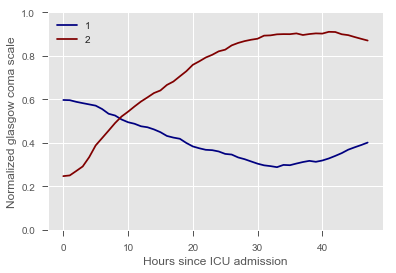

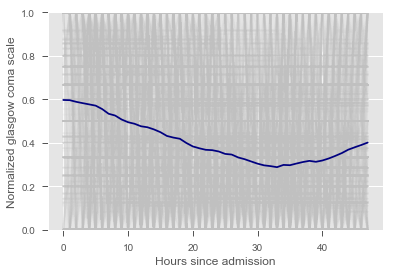

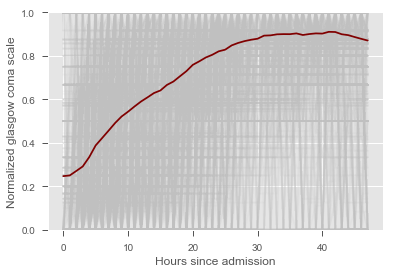

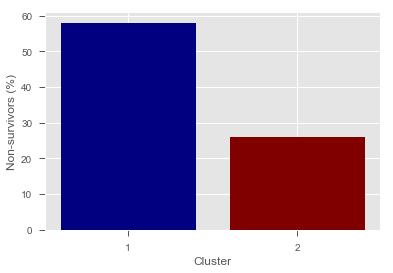

Using 2139 ICU stays for creating the clusters
3 clusters
Cluster 1: 631 observations
Cluster 2: 686 observations
Cluster 3: 822 observations


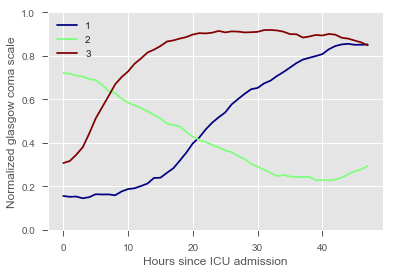

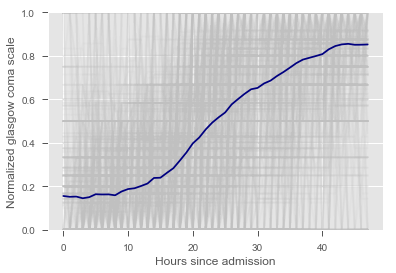

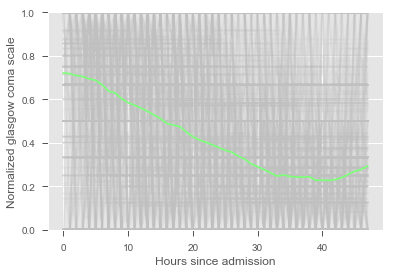

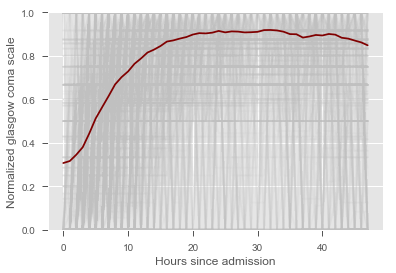

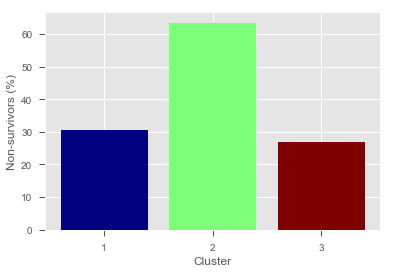

Using 2139 ICU stays for creating the clusters
4 clusters
Cluster 1: 585 observations
Cluster 2: 589 observations
Cluster 3: 461 observations
Cluster 4: 504 observations


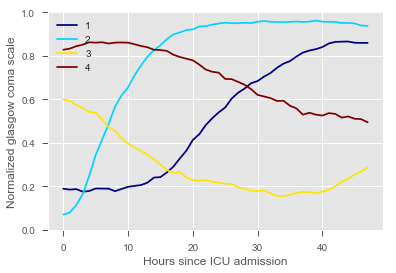

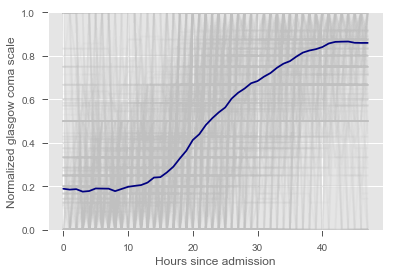

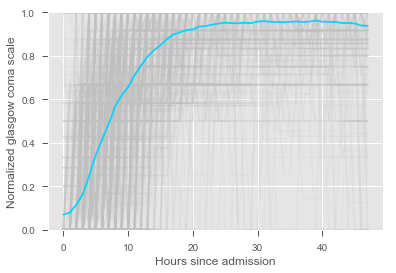

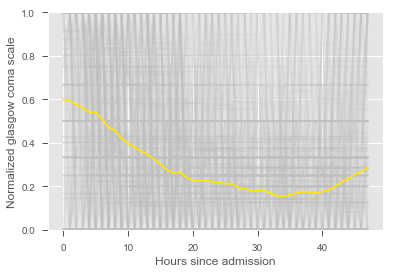

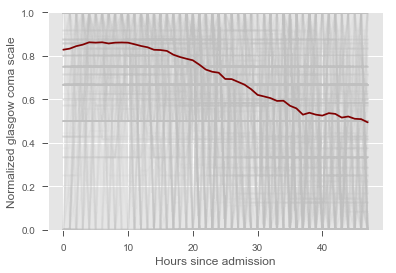

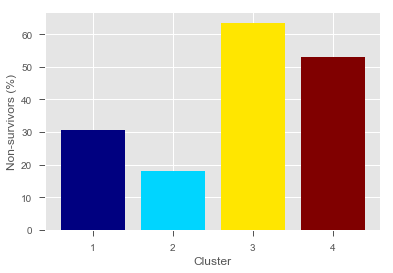

Using 2139 ICU stays for creating the clusters
5 clusters
Cluster 1: 337 observations
Cluster 2: 481 observations
Cluster 3: 333 observations
Cluster 4: 519 observations
Cluster 5: 469 observations


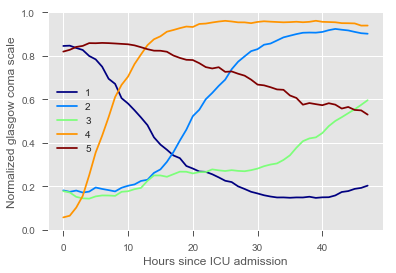

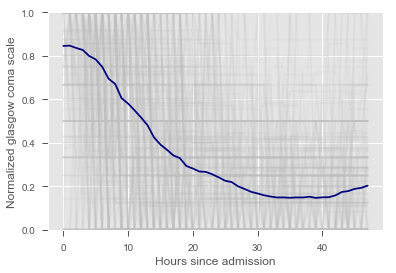

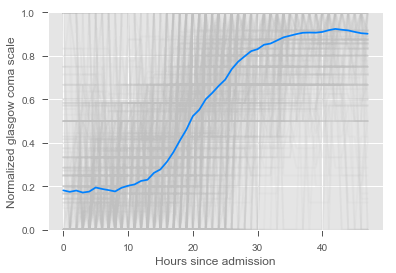

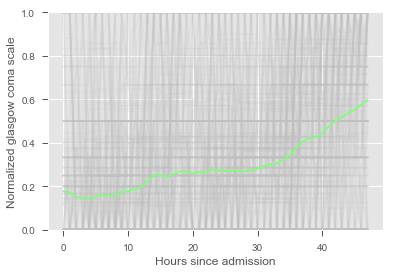

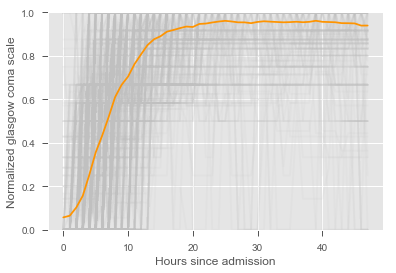

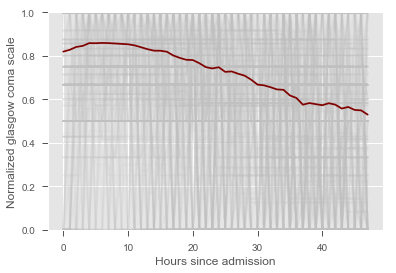

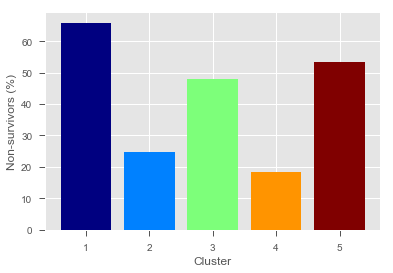

In [24]:
variable = 'glasgow coma scale'
K_max = 6
# ids_clustering = data_transf_inv.index.unique()
ids_clustering = X_train.index.unique()

for K in range(2, K_max):
    data4clustering, cluster_labels = clustering(variable, ids_clustering, K)

In the example, clustering is performed for glasgow coma scale (GCS), for a varying number of clusters. The cluster centers are shown, as well as the training data in each cluster. The bar plot shows the percentage of non-survivors in each cluster.

The idea is to assess the quality of the clusters in a qualitative way, rather than resorting to quantitative methods typically known as cluster validity indices. 

* $K = 2$
    * shows two very distinct patterns, similar to what we found by partitioning by mortality.
    * but, we want some more stratification.
* $K = 3$
    * 2 groups where GCS is improving with time.
    * 1 group where GCS is deteriorating.
    * yes, this is reflected in terms of our ground truth labels, even though we did not provide that information to the clustering. Mortality$>60\%$ in one cluster vs $30\%$ and $28\%$ in the other two clusters.
* $K = 4$
    * one more "bad" cluster appears.
* $K = 5$
    * Clusters 2 and 4 have similar patterns and similar mortality distribution. GCS is improving with time. 
    * Clusters 3 and 5 have similar mortality distribution. GCS is slowly increasing or decreasing with time.
    * Cluster 1 is the "worst" cluster. Mortality is close to $70\%$.

In summary, every $K$ that we studied gives us an interesting view of the evolution of GCS and its relation with mortality. For the sake of simplicity, this analysis is only shown for GCS. The choice of the number of clusters for the remaining variables has been made likewise.

Next we are going to perform clustering for each variable, and predict cluster labels for new data. Cluster labels will be used to add another layer of information to our machine learning models.

### 7.3.2. Training and testing

* Training phase: perform clustering using the traininig data.

* Test phase: assign new observations to one of the clusters defined in the training phase. Each observation is assigned to the most similar cluster, i.e., to the cluster whose center is at a smaller distance.

diastolic BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 633 observations
Cluster 2: 414 observations
Cluster 3: 658 observations
Cluster 4: 647 observations


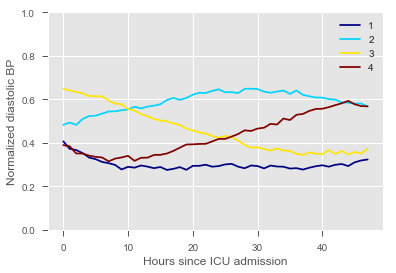

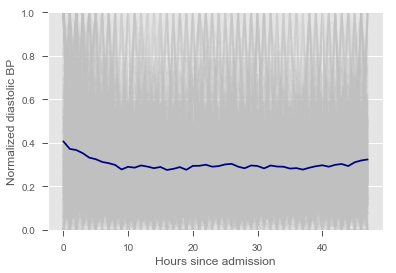

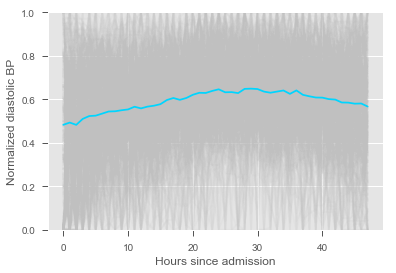

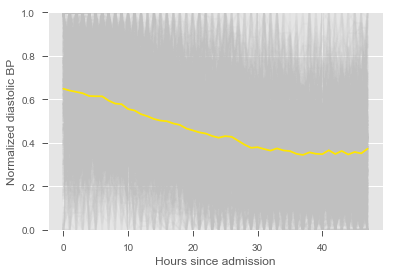

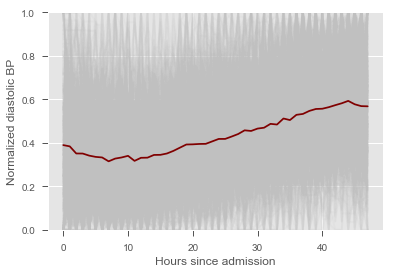

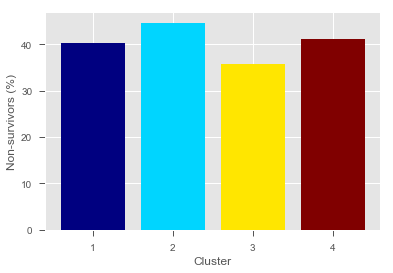

glasgow coma scale
Using 2139 ICU stays for creating the clusters
Using 1251 ICU stays for cluster assignment
4 clusters
Cluster 1: 585 observations
Cluster 2: 589 observations
Cluster 3: 461 observations
Cluster 4: 504 observations


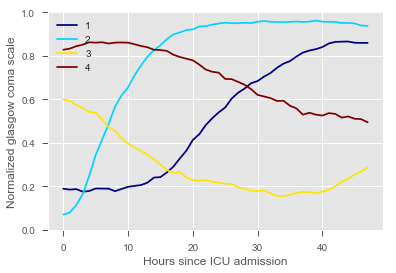

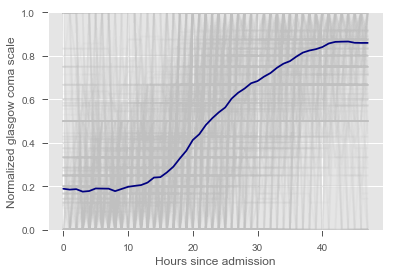

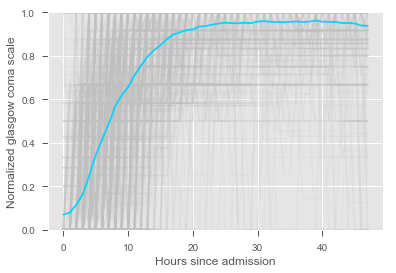

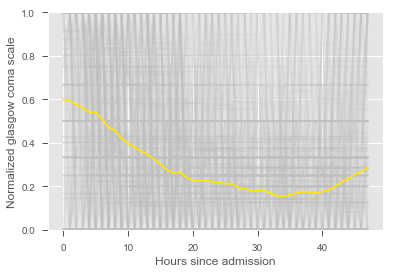

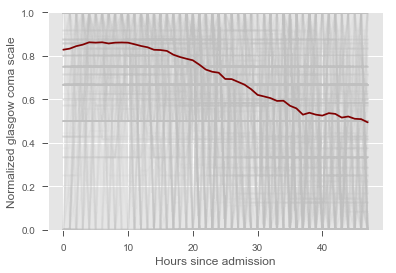

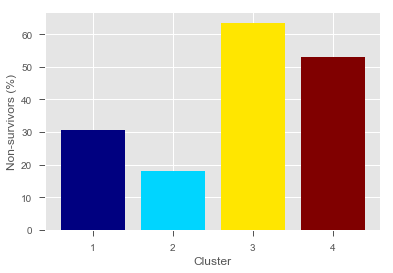

glucose
Using 2351 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 362 observations
Cluster 2: 716 observations
Cluster 3: 431 observations
Cluster 4: 398 observations
Cluster 5: 444 observations


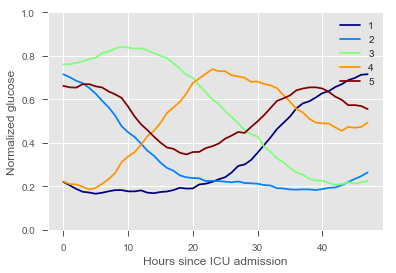

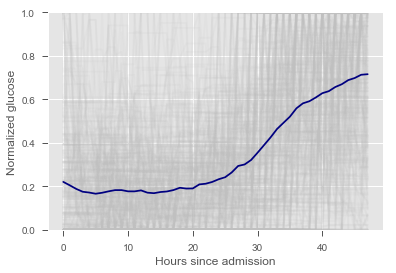

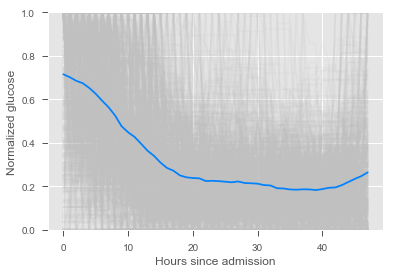

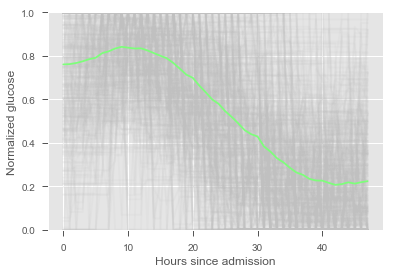

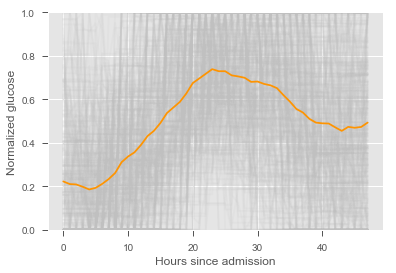

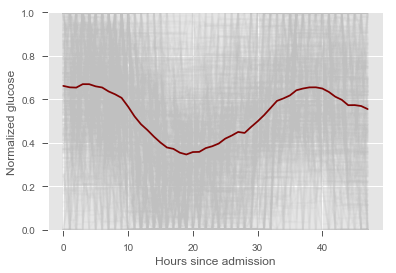

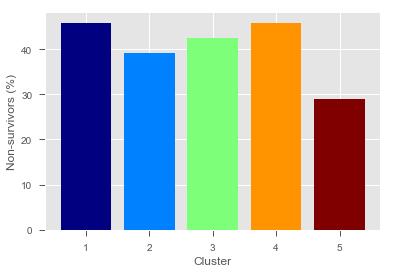

heart rate
Using 2350 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 455 observations
Cluster 2: 455 observations
Cluster 3: 452 observations
Cluster 4: 482 observations
Cluster 5: 506 observations


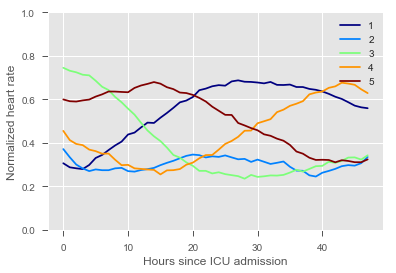

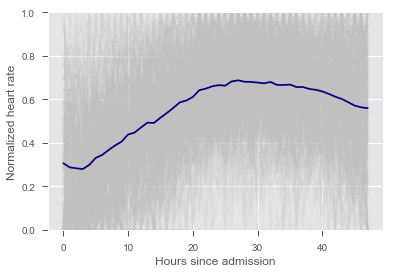

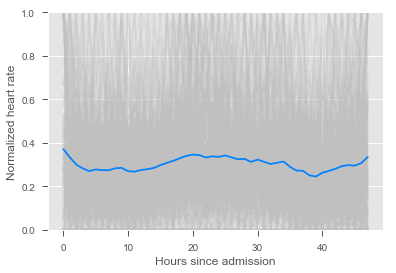

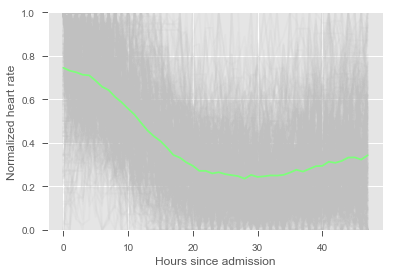

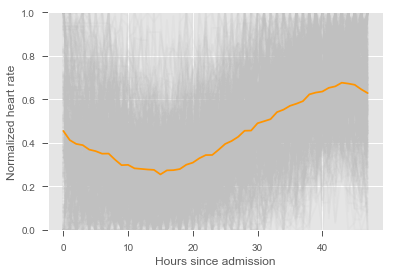

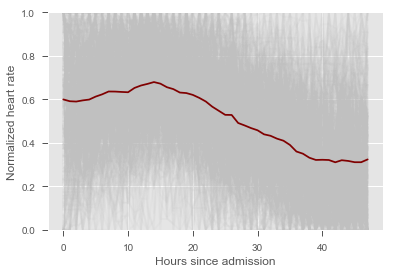

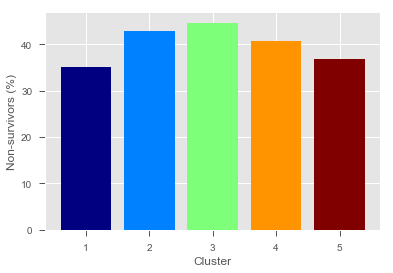

mean BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 505 observations
Cluster 2: 499 observations
Cluster 3: 526 observations
Cluster 4: 381 observations
Cluster 5: 441 observations


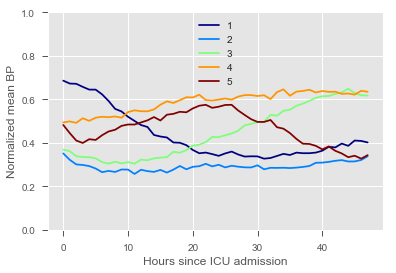

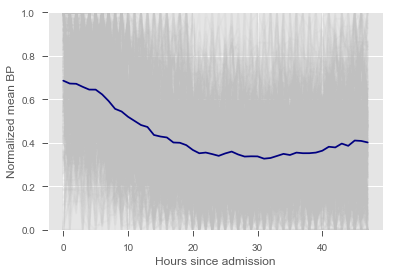

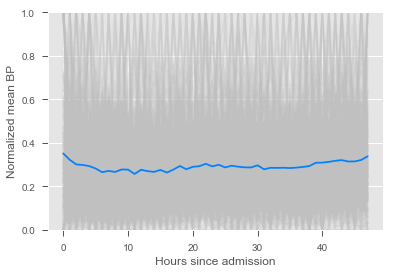

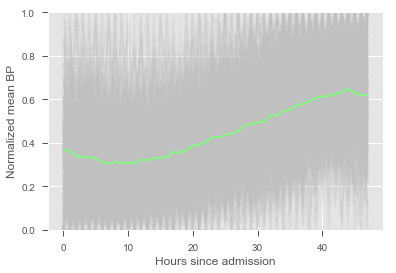

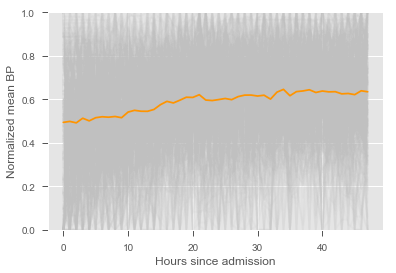

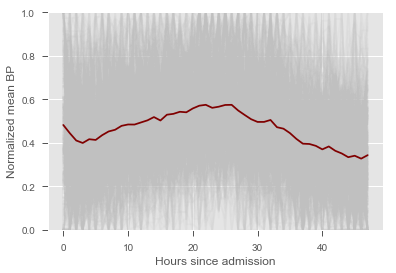

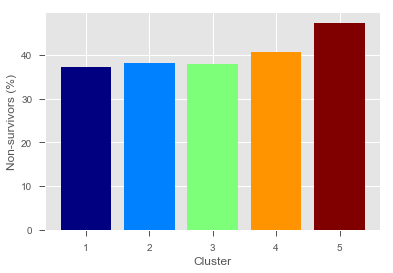

oxygen saturation
Using 2344 ICU stays for creating the clusters
Using 1378 ICU stays for cluster assignment
3 clusters
Cluster 1: 466 observations
Cluster 2: 1143 observations
Cluster 3: 735 observations


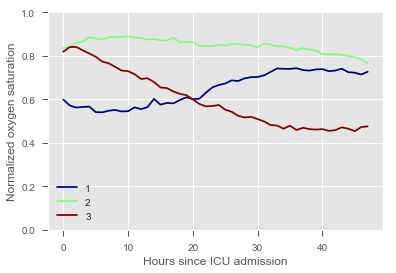

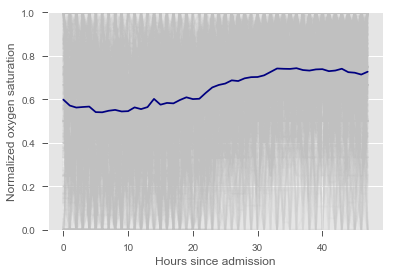

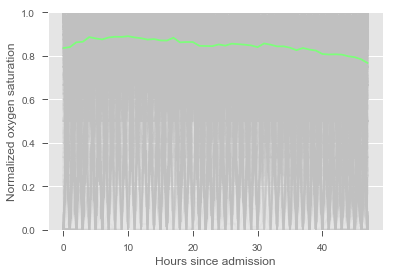

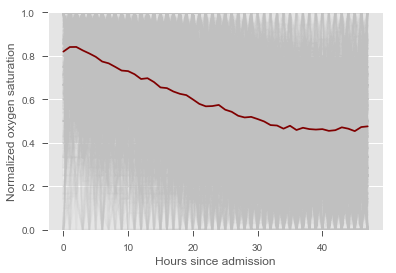

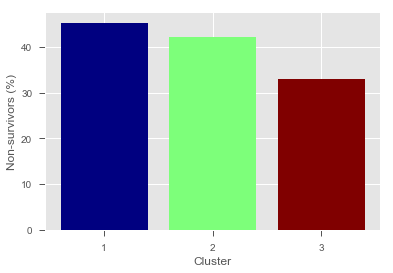

respiratory rate
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
5 clusters
Cluster 1: 385 observations
Cluster 2: 500 observations
Cluster 3: 516 observations
Cluster 4: 468 observations
Cluster 5: 483 observations


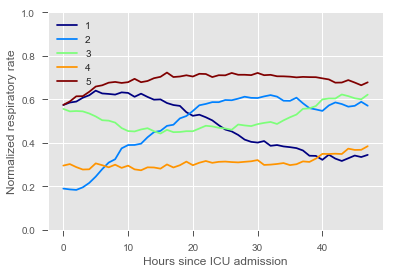

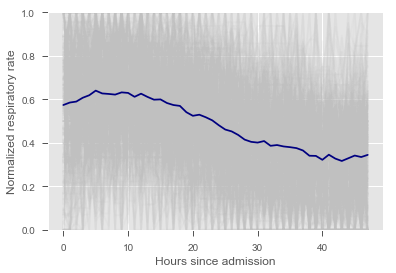

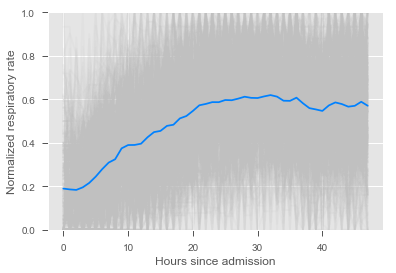

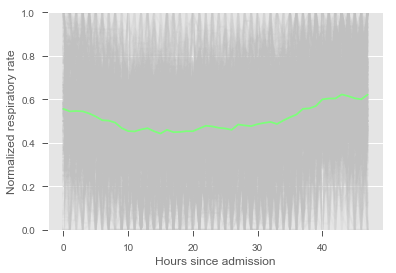

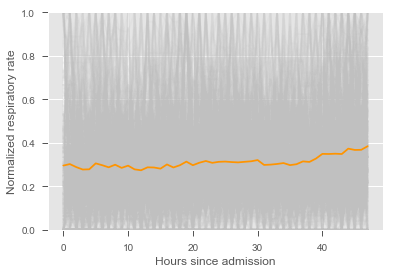

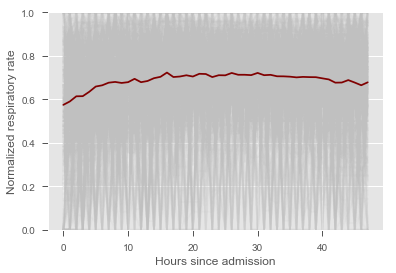

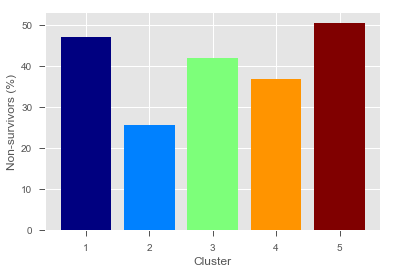

systolic BP
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 653 observations
Cluster 2: 586 observations
Cluster 3: 574 observations
Cluster 4: 539 observations


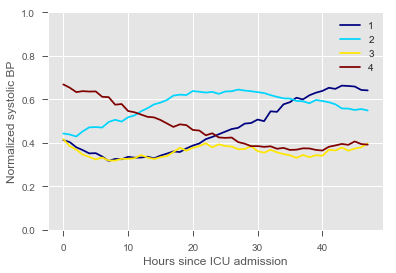

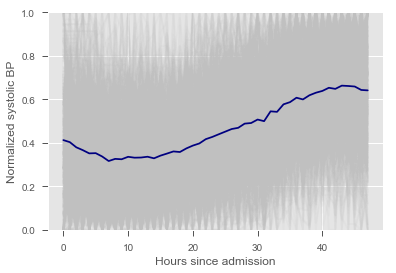

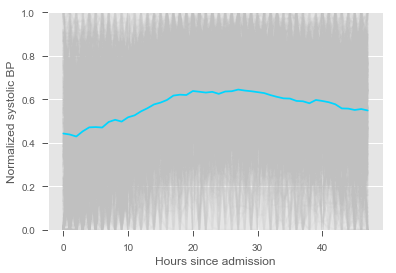

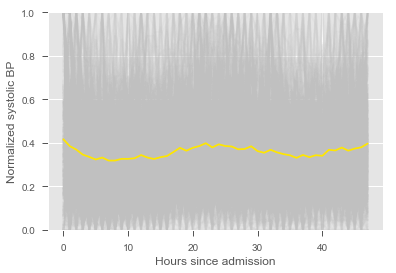

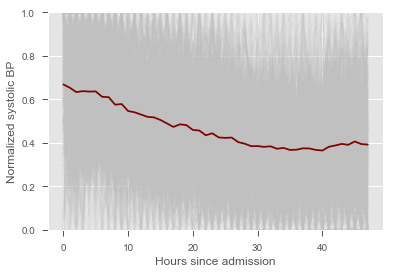

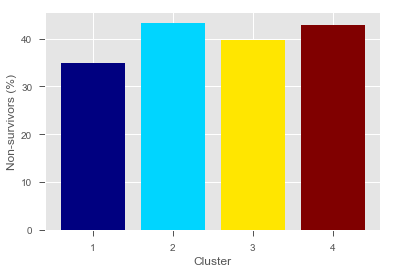

temperature
Using 2352 ICU stays for creating the clusters
Using 1387 ICU stays for cluster assignment
4 clusters
Cluster 1: 472 observations
Cluster 2: 695 observations
Cluster 3: 561 observations
Cluster 4: 624 observations


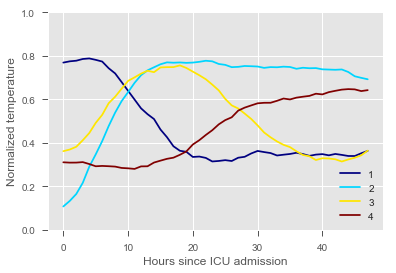

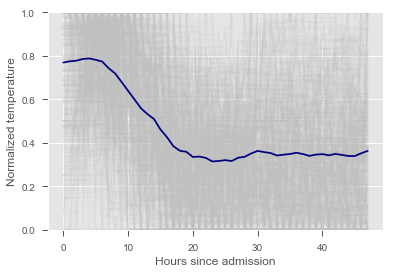

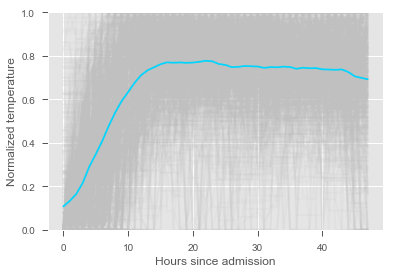

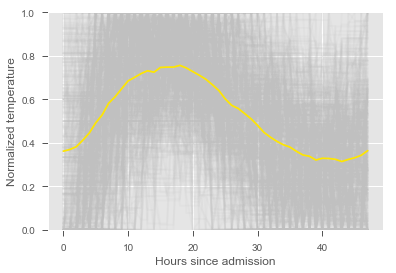

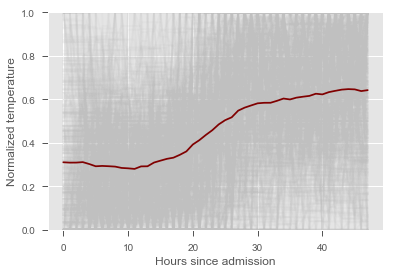

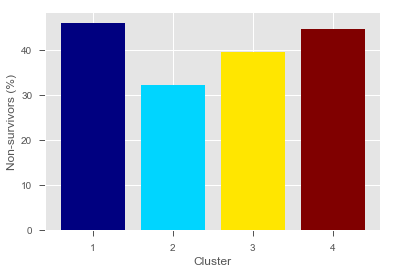

pH
Using 2326 ICU stays for creating the clusters
Using 1363 ICU stays for cluster assignment
4 clusters
Cluster 1: 472 observations
Cluster 2: 789 observations
Cluster 3: 643 observations
Cluster 4: 422 observations


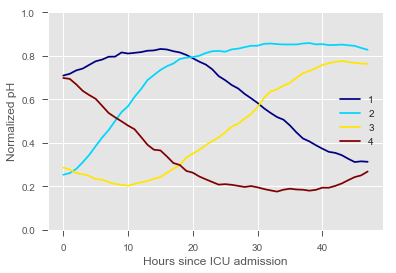

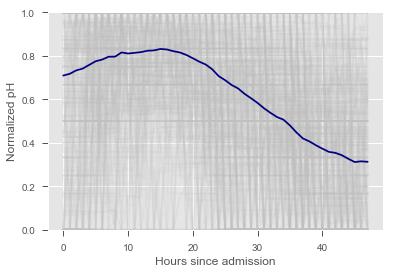

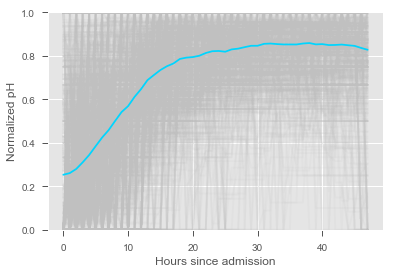

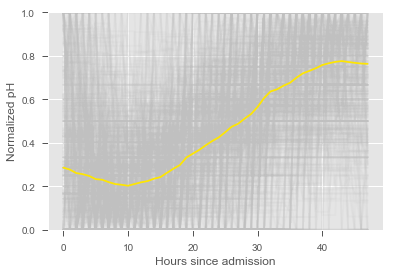

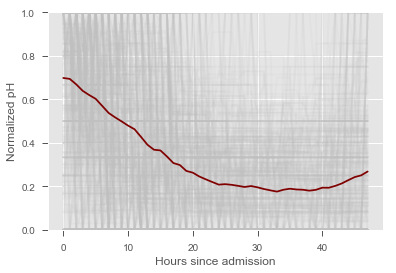

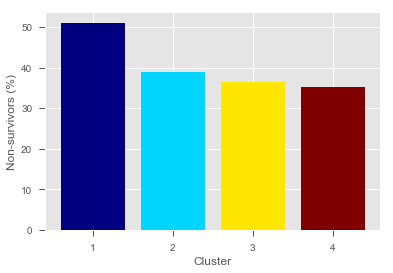

In [25]:
Ks = dict([('diastolic BP', 4), 
           ('glasgow coma scale', 4),
           ('glucose', 5),
           ('heart rate', 5),
           ('mean BP', 5),
           ('oxygen saturation', 3),
           ('respiratory rate', 5),
           ('systolic BP', 4),
           ('temperature', 4),
           ('pH', 4),
          ])

id_train = X_train.index.unique()
id_test = X_test.index.unique()
cluster_labels_train = pd.DataFrame()
cluster_labels_test = pd.DataFrame()
for feature in variables:
    print(feature)
    K = Ks[feature]
    data4clustering, labels_train, labels_test = clustering(feature, id_train, K, id_test)

    labels_test.columns=['CL ' + feature]
    labels_train.columns=['CL ' + feature]
    
    cluster_labels_train = pd.concat([cluster_labels_train, labels_train], axis=1).dropna(axis=0)
    cluster_labels_test = pd.concat([cluster_labels_test, labels_test], axis=1).dropna(axis=0)

for col in cluster_labels_train:
    cluster_labels_train[col] = cluster_labels_train[col].astype('category')

for col in cluster_labels_test:
    cluster_labels_test[col] = cluster_labels_test[col].astype('category')
    

Clustering allowed us to stratify patients according to their physiological evolution over 48 hours. The cluster centers reflect the cluster tendency. Like before, we can look at the centers and mortality distribution and try to understand if there is a relation, and if that relation is expected.

For example, cluster 4 and cluster 5 in glucose are more or less symmetric: in cluster 4 the patients start with low glucose and it increases over time until it decreases and in cluster 5 the patients start with high glucose and it decreases over time until it increases again. In the first case, mortality is approximately $45\%$, and in the second case it is approximately $30\%$. Although this is obviously not enough to predict mortality, it highlights a possible relationship between the evolution of glucose and mortality. If a certain patient has a pattern of glucose similar to cluster 4, there may be more reason for concern than if he/she expresses the pattern in cluster 5.

By now, some particularities of the type of normalization we performed can be noted:

* It hinders interpretability.
* It allows the algorithm to group together patients that did not present significant changes in their physiological state through time, regardless of the absolute value of the measurements. 

We have seen how clustering can be used to stratify populations. Next we are going to create models that use the information provived by clustering. Models will be created for the extracted features together with cluster information.

## 7.4. Normalize the extracted features

Normalize the extracted features before concatenating cluster labels. 

Note that:

* The data is normalized for the entire dataset at once, and not for each patient individually.

* Normalization is useful when solving for example least squares or functions involving the calculation of distances. Normalization does not impact the performance of a decision tree. 

## 7.5. Concatenate predicted clustering labels with input data

In [26]:
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train_norm = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test_norm = (X_test - X_train_min) / (X_train_max - X_train_min)

In [27]:
# drop_first : bool, default False
# Whether to get k-1 dummies out of k categorical levels by removing the first level.
# binary indicator representation = dummy
# use drop_first=True to discard one of the categories

X_train_clust = pd.get_dummies(cluster_labels_train, prefix_sep=' ')
y_train_clust = pd.DataFrame(data_transf_inv.loc[cluster_labels_train.index]['mortality'])
X_test_clust = pd.get_dummies(cluster_labels_test, prefix_sep=' ')
y_test_clust = pd.DataFrame(data_transf_inv.loc[cluster_labels_test.index]['mortality'])

X_train_transf_clust = pd.concat([X_train, X_train_clust], axis=1).dropna(axis=0)
y_train_transf_clust = y_train.loc[X_train_transf_clust.index]
X_train_transf_clust_norm = pd.concat([X_train_norm, X_train_clust], axis=1).dropna(axis=0)

X_test_transf_clust = pd.concat([X_test, X_test_clust], axis=1).dropna(axis=0)
y_test_transf_clust = y_test.loc[X_test_transf_clust.index]
X_test_transf_clust_norm = pd.concat([X_test_norm, X_test_clust], axis=1).dropna(axis=0)

print('Number of observations in training set: ' + str(X_train_transf_clust.shape[0]))
print('Number of observations in test set: ' + str(X_test_transf_clust.shape[0]))
print('Number of features: ' + str(X_test_transf_clust.shape[1]))

display.display(X_train_transf_clust.head())

Number of observations in training set: 2110
Number of observations in test set: 1232
Number of features: 85


min diastolic BP  min glasgow coma scale  min glucose  \
icustay                                                           
200019.0              30.0                     6.0        117.0   
200220.0              41.0                     6.0        140.0   
200250.0              41.0                     7.0         99.5   
200379.0              32.0                     3.0         95.0   
200488.0              50.0                     9.0         75.0   

          min heart rate  min mean BP  min oxygen saturation  \
icustay                                                        
200019.0            42.0    64.333298                   95.0   
200220.0            91.0    72.000000                   97.0   
200250.0            83.0    56.333302                   96.0   
200379.0            69.0    52.333302                   93.0   
200488.0            68.0    65.000000                   89.5   

          min respiratory rate  min systolic BP  min temperature  min pH  \
icustay                                                                    
200019.0                  11.0            129.0        36.166698    7.36   
200220.0                   9.0            112.0        35.222223    7.23   
200250.0                   0.5             87.0        36.000002    7.35   
200379.0                   9.0             89.0        36.166698    7.39   
200488.0                   3.0             89.0        36.833335    7.43   

            ...      CL systolic BP 2.0  CL systolic BP 3.0  \
icustay     ...                                               
200019.0    ...                     0.0                 1.0   
200220.0    ...                     1.0                 0.0   
200250.0    ...                     1.0                 0.0   
200379.0    ...                     0.0                 1.0   
200488.0    ...                     0.0                 1.0   

          CL temperature 0.0  CL temperature 1.0  CL temperature 2.0  \
icustay                                                                
200019.0                 1.0                 0.0                 0.0   
200220.0                 1.0                 0.0                 0.0   
200250.0                 0.0                 0.0                 0.0   
200379.0                 0.0                 0.0                 1.0   
200488.0                 0.0                 0.0                 1.0   

          CL temperature 3.0  CL pH 0.0  CL pH 1.0  CL pH 2.0  CL pH 3.0  
icustay                                                                   
200019.0                 0.0        0.0        0.0        0.0        1.0  
200220.0                 0.0        0.0        0.0        1.0        0.0  
200250.0                 1.0        1.0        0.0        0.0        0.0  
200379.0                 0.0        0.0        0.0        1.0        0.0  
200488.0                 0.0        0.0        0.0        1.0        0.0  

[5 rows x 85 columns]

Note that 

* CL 0.0 is cluster 1 
* CL 1.0 is cluster 2
* ...

# 8. Modeling

8.1. Definition of performance measures

8.2. k-Nearest neighbors

8.3. Logistic regression

8.4. Decision tree

8.5. Random Forest

## 8.1. Definition of performance measures

Having a single-number evaluation metric is useful for comparing the performance of different models. 

Accuracy can be misleading when classes are imbalanced, such as in the dataset we are using. Here, **sensitivity** (also called recall or true positive rate) is a useful measure that indicates the percentage of non-survivors who are correctly identified as such. In the context of our problem, having a high **sensitivity** is very important, since it tells us the algorithm is able to correctly identify the most critical cases. However, optimizing for sensitivity alone may lead to the presence of many false alarms (false positives). Therefore, we will also have in mind the models **specificity**, which tells us the the percentage of survivors who are correctly identified as such.

* Sensitivity = $\frac{TP}{TP + FN}$
* Specificity = $\frac{TN}{TN + FP}$

One way of combining **sensitivity** and **specificity** in one measure is using the area under the receiver–operator characteristics (ROC) curve (AUC), which is a graphical plot that illustrates the performance of a binary classifier as its discrimination threshold is varied.  

In [28]:
def performance(y, y_pred, print_, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a predifined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds. """
    frames = []
    for x in range(101, -2, -1):
        threshold = x/100
        y_pred_class = y_pred.copy()
        y_pred_class[y_pred_class >= threshold] = 1
        y_pred_class[y_pred_class < threshold] = 0

        compare_class = np.concatenate([y, y_pred_class], axis=1)

        tp = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 1)))
        tn = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 0)))
        fp = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 1)))
        fn = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 0)))
  
        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        FPR = 1 - specificity
        difference = np.abs(sensitivity-specificity)
        frames.append((threshold, tp, tn, fp, fn, sensitivity, specificity, FPR, difference))

    performance_thr = pd.DataFrame(frames, columns=('threshold', 'tp', 'tn', 'fp', 'fn', 'sensitivity', 'specificity', 'FPR', 'difference'))

    if args:
        threshold = args[0]
        # print('TEST SET')
    else:
        id_min = performance_thr.loc[performance_thr['difference'].idxmin()]
        threshold = id_min.loc['threshold']
        # print('TRAINING SET')
        
    y_pred_class = y_pred.copy()
    y_pred_class[y_pred_class >= threshold] = 1
    y_pred_class[y_pred_class < threshold] = 0
    compare_class = np.concatenate([y, y_pred_class], axis=1)

    tp = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 1)))
    tn = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 0)))
    fp = np.size(np.where((compare_class[:,0] == 0) & (compare_class[:,1] == 1)))
    fn = np.size(np.where((compare_class[:,0] == 1) & (compare_class[:,1] == 0)))

    
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
           
    # Alternatively, use:
    # from scipy.integrate import quad
    # AUC = np.trapz(performance_thr['sensitivity'], x = performance_thr['FPR'])
    # print('AUC: ' + str(AUC))
    
    AUC = 0
    for row, performance in performance_thr.iloc[:-1].iterrows():
        row = row + 1
        AUC = AUC + ((performance_thr.loc[row]['FPR']) - (performance_thr.loc[row - 1]['FPR'])) * ((performance_thr.loc[row]['sensitivity']+performance_thr.loc[row-1]['sensitivity'])/2)
    
    if print_ == 1:
        print('Threshold: ' + str(threshold))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        print("Accuracy: " + str( round((tp + tn) / (tp + tn + fp + fn), 2 )))
        print('Sensitivity: ' + str(round(sensitivity,2)))
        print('Specificity: ' + str(round(specificity,2)))                
        print('AUC: ' + str(round(AUC,2)))
    
        plt.figure()
        plt.scatter(x = performance_thr['FPR'], y = performance_thr['sensitivity'], label = None)
        plt.plot(performance_thr['FPR'], performance_thr['sensitivity'], label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - specificity, y = sensitivity, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        #plt.savefig('auc.png')
        plt.show()
        

    return threshold, AUC, sensitivity, specificity


In [29]:
def model_evaluation(model, X_train, y_train, X_test, y_test, print_):
    
    # tune - parameter estimation 
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, AUC_train, sens_train, spec_train = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

    # test
    y_pred_prob_test = model.predict_proba(X_test)

    _, AUC_test, sens_test, spec_test = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)
    
    return threshold, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test


In [30]:
def print_coef(model, X_train):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(np.transpose(model.coef_), index = X_train.columns, columns = ['Coefficients'])
    coef = coef.sort_values(by=['Coefficients'])
    coef.plot(kind = 'bar', figsize=(15, 6))
    plt.xticks(rotation='vertical', horizontalalignment='right')
    plt.show()

## 8.2. k-Nearest neighbors (kNN)

Threshold: 1.0
TP: 626
TN: 1270
FP: 141
FN: 315
Accuracy: 0.81
Sensitivity: 0.67
Specificity: 0.9
AUC: 0.78


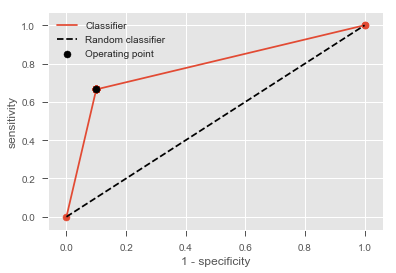

Threshold: 1.0
TP: 95
TN: 896
FP: 245
FN: 151
Accuracy: 0.71
Sensitivity: 0.39
Specificity: 0.79
AUC: 0.59


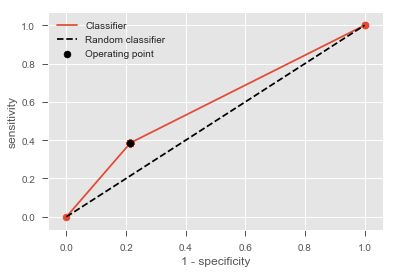

In [31]:
from sklearn.neighbors import KNeighborsClassifier

all_results_train = pd.DataFrame(index=['AUC', 'Sensitivity', 'Specificity', '# Features'])
all_results_test = pd.DataFrame(index=['AUC', 'Sensitivity', 'Specificity', '# Features'])

# instantiate learning model
knn = KNeighborsClassifier(n_neighbors = 3)

# fitting the model
knn.fit(X_train, y_train.values.ravel())

# predict the response
y_pred_train = knn.predict(X_train)
y_pred = knn.predict(X_test)

print_ = 1
_, AUC_train, sens_train, spec_train = performance(y_train, pd.DataFrame(y_pred_train), print_)
_, AUC_test, sens_test, spec_test = performance(y_test, pd.DataFrame(y_pred), print_)

#all_results_train['knn'] = [AUC_train, sens_train, spec_train, len(X_train.columns)]
#all_results_test['knn'] = [AUC_test, sens_test, spec_test, len(X_train.columns)]


## 8.3. Logistic regression

When starting a machine learning project it is always a good approach to start with a very simple model. The simple model will give a sense of how challenging the question is. In order to estimate the performance of a simple logistic regression model, we are going to ignore multicollinearity for a while and use all of the available features.

Multicollinearity exists when two or more of the predictors in a regression model are moderately or highly correlated. The problem with multicollinearity is that it makes some variables statistically insignificant when they are not necessarily so, because the estimated coefficient of one variable depends on which colinear variables are included in the model. High multicollinearity increases the variance of the regression coefficients, making them unstable, but a little bit of multicollinearity isn't necessarily a problem. 


### 8.3.1. Using transformed features

Threshold: 0.4
TP: 725
TN: 1084
FP: 327
FN: 216
Accuracy: 0.77
Sensitivity: 0.77
Specificity: 0.77
AUC: 0.85


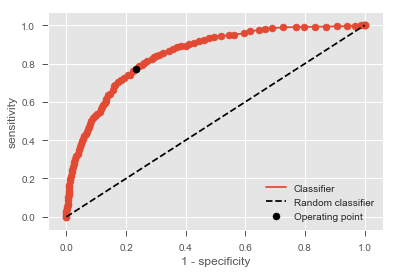

Threshold: 0.4
TP: 184
TN: 854
FP: 287
FN: 62
Accuracy: 0.75
Sensitivity: 0.75
Specificity: 0.75
AUC: 0.83


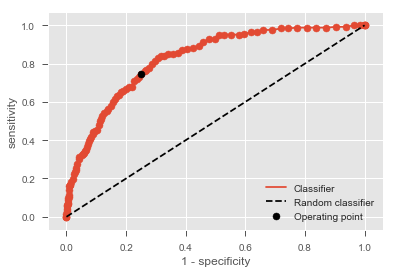

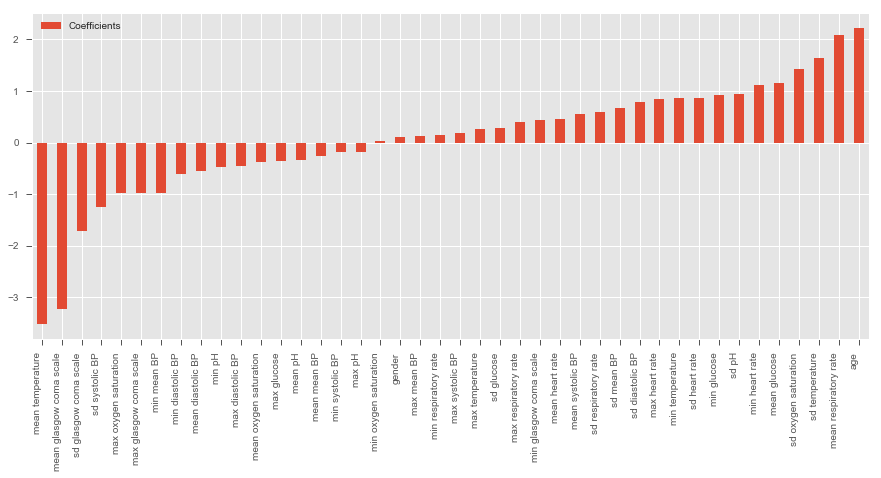

In [32]:
# import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

print_ = 1

model = LogisticRegression(random_state = 1)
model.fit(X_train_norm, y_train.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(model, X_train_norm, y_train, X_test_norm, y_test, print_)
print_coef(model, X_train_norm)

all_results_train['LR transf'] = [AUC_train, sens_train, spec_train, len(X_train_norm.columns)]
all_results_test['LR transf'] = [AUC_test, sens_test, spec_test, len(X_train_norm.columns)]


Age, GCS and abnormal vitals (RR, BP, HR, etc) are most strongly correlated with mortality (these all obviously make sense). What we find interesting and a little unexpected is the strong negative correlation between mean temperature and mortality.

### 8.3.2. Using cluster labels

Threshold: 0.41
TP: 571
TN: 884
FP: 394
FN: 261
Accuracy: 0.69
Sensitivity: 0.69
Specificity: 0.69
AUC: 0.74


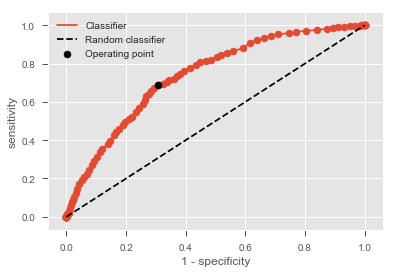

Threshold: 0.41
TP: 150
TN: 694
FP: 316
FN: 72
Accuracy: 0.69
Sensitivity: 0.68
Specificity: 0.69
AUC: 0.73


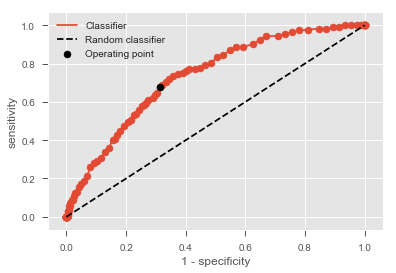

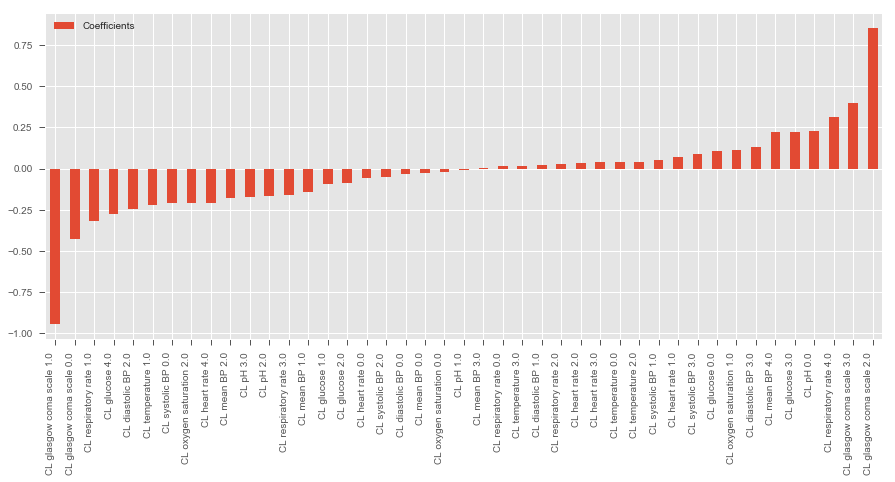

In [33]:
print_ = 1

model = LogisticRegression(random_state = 1)
model.fit(X_train_clust, y_train_clust.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(model, X_train_clust, y_train_clust, X_test_clust, y_test_clust, print_)
print_coef(model, X_train_clust)

all_results_train['LR cluster labels'] = [AUC_train, sens_train, spec_train, len(X_train_clust.columns)]
all_results_test['LR cluster labels'] = [AUC_test, sens_test, spec_test, len(X_train_clust.columns)]


### 8.3.3. Using transformed features and cluster labels

Threshold: 0.41
TP: 657
TN: 1014
FP: 264
FN: 175
Accuracy: 0.79
Sensitivity: 0.79
Specificity: 0.79
AUC: 0.87


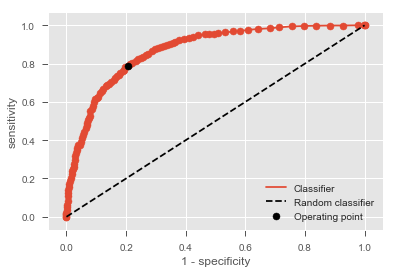

Threshold: 0.41
TP: 165
TN: 775
FP: 235
FN: 57
Accuracy: 0.76
Sensitivity: 0.74
Specificity: 0.77
AUC: 0.84


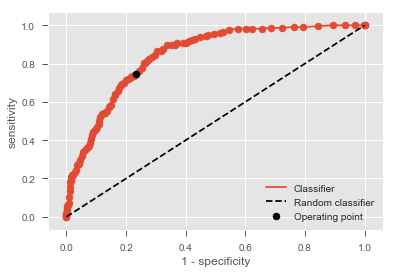

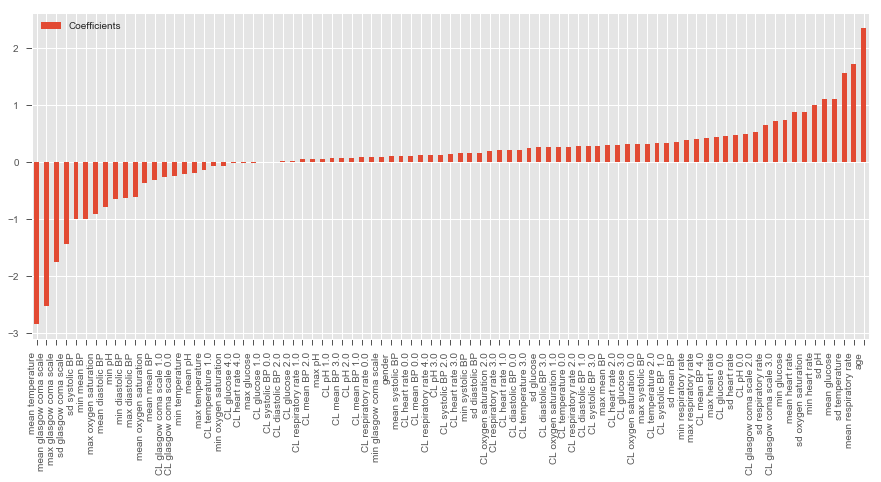

In [34]:
print_ = 1

model = LogisticRegression(random_state = 1)
model.fit(X_train_transf_clust_norm, y_train_transf_clust.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(model, X_train_transf_clust_norm, y_train_transf_clust, X_test_transf_clust_norm, y_test_transf_clust, print_)
print_coef(model, X_train_transf_clust_norm)

all_results_train['LR transf + clust labels'] = [AUC_train, sens_train, spec_train, len(X_train_transf_clust_norm.columns)]
all_results_test['LR transf + clust labels'] = [AUC_test, sens_test, spec_test, len(X_train_transf_clust_norm.columns)]


The cluster labels seem to slighlty increase the performance of the model trained with transformed features, but we certainly do not want to use this model due to the high dimensionality.

Again, we find that age, GCS and abnormal vitals (RR, BP, HR, etc) are most strongly correlated with mortality (these all obviously make sense), and a strong unexpected correlation between poor mean temperature and mortality.


### 8.3.4. Feature selection

In order to reduce multicollinearity, and because we are interested in increasing the interpretability and simplicity of our model, feature selection is highly recommended.

#### a) Sequential forward selection / forward stepwise selection

The sequential forward selection (SFS) algorithm is an iterative process where the subset of features that best predicts the output is obtained by sequentially selecting features until there is no improvement in prediction. The criterion used to select features and to determine when to stop is chosen based on the objectives of the problem. Here, we will use the average sensitivity and specificity.

In order to evaluate the feature sets, the training data is divided into two sets, one for training and other for validation. In the first iteration, models with one feature are created (univariable analysis). The model giving the higher average sensitivity and specificity in the validation set is selected. In the second iteration, the remaining features are evaluated again one at a time, together with the feature selected in the previous iteration. This process continues until there is no significant improvement in performance. For simplicity, we will use a minimum improvement of 0.01 to visualize the algorithm for a few iterations. The figure shows the performance associated with each feature at each iteration of the algorithm. Different iterations have different colors and at each iteration one feature is selected and marked with a red dot.

Remember that for large number of features (85 in our case) we cannot compute the best subset sequence. This would mean testing all combinations of 85 features, 1 to 85 at a time. It is hard enough to calculate the number of combinations, let alone train models for every one of them! That's why we use greedy algorithms that lead to sub-optimal solutions.

In [35]:
test_size = 0.4
use_test_set = 1
min_improv = 0.01
#min_improv = 0.0005

if use_test_set == 1:
    # Use this if you want to use a test set for feature selection
    X_train_SFS, X_test_SFS, y_train_SFS, y_test_SFS = data_partioning(pd.concat([X_train_norm, y_train], axis = 1), test_size, 0, 1)
else:
    # Use this if you want to use only a training set for feature selection
    X_train_SFS = X_train_norm.copy()
    X_test_SFS = X_train_norm.copy()
    y_train_SFS = y_train.copy()
    y_test_SFS = y_train.copy()


570(40.4%) non-survivors in training set
841(59.6%) survivors in training set
371(39.43%) non-survivors in test set
570(60.57%) survivors in test set



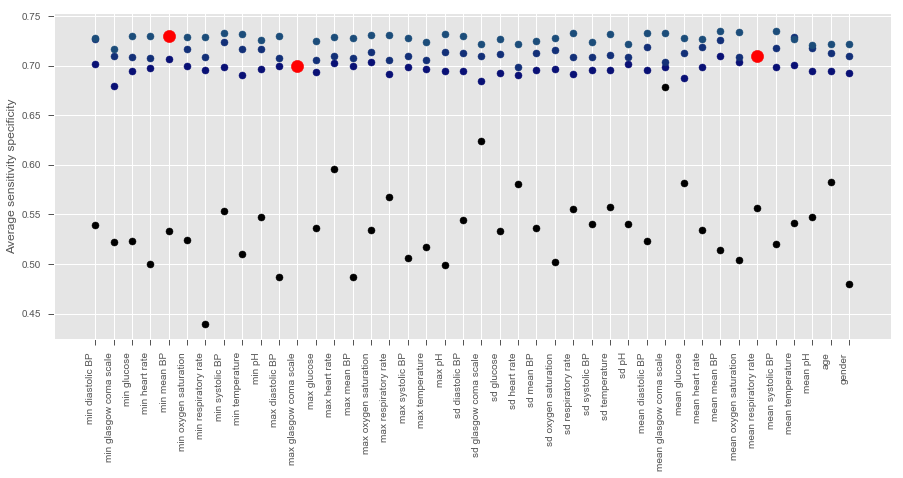

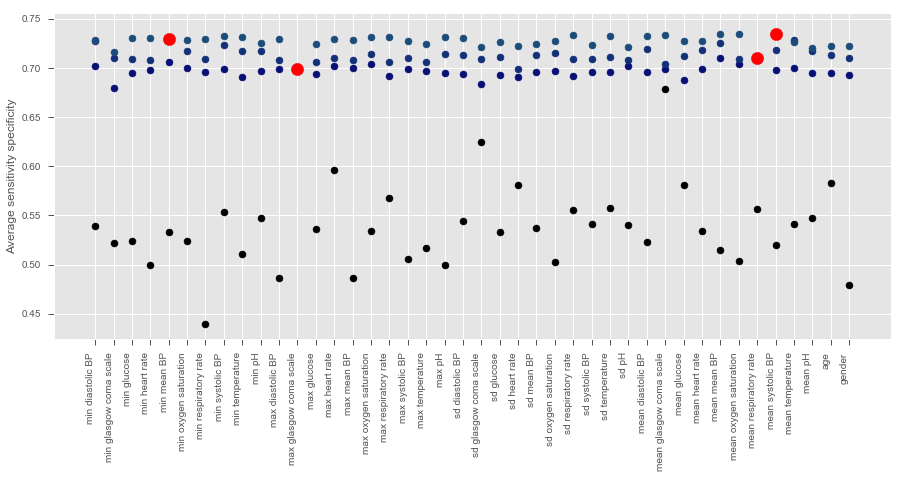

In [36]:
from matplotlib import cm

to_test_features = X_train_norm.columns
selected_features_sfs = []
test_set = []
results_selected = []
print_ = 0
previous_perf = 0
gain = 1
it = 0

plt.figure(num=None, figsize=(15, 6))
#plt.xticks(rotation=30, horizontalalignment='right')
plt.xticks(rotation='vertical', horizontalalignment='right')
plt.ylabel('Average sensitivity specificity')

colors = cm.gist_earth(np.linspace(0, 1, 180))
colors = colors[::10]
    
while gain >= min_improv:
    frames = []
    color = colors[it]
    it += 1
    # print('Iteration ' + str(it))
    #color = np.random.rand(3,)

    for col in to_test_features:
        test_set = selected_features_sfs.copy()
        test_set.append(col)
        
        model = LogisticRegression(random_state = 1)
        model.fit(X_train_SFS[test_set], y_train_SFS.values.ravel())
                    
        y_pred_prob = model.predict_proba(X_test_SFS[test_set]) 
        _, AUC, sens, spec = performance(y_test_SFS, np.delete(y_pred_prob, 0, 1), print_)

        frames.append([test_set, (sens+spec)/2])
        
        plt.scatter(x = col, y = (sens+spec)/2, c = color)       
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)
        
    results = pd.DataFrame(frames, columns=('Feature', 'Performance'))
    id_max = results.loc[results['Performance'].idxmax()]
    gain = id_max['Performance'] - previous_perf
    
    plt.scatter(x = id_max['Feature'][-1], y = id_max['Performance'], c = 'red', s = 150)
    
    if gain > min_improv:
        previous_perf = id_max['Performance']
        to_test_features = to_test_features.drop(id_max['Feature'][-1])
        selected_features_sfs.append(id_max['Feature'][-1])
        results_selected.append(id_max)
    # print('Gain in performance: ' + str(gain))
    # else dont had the last to the feature set, will exit the loop

# results_selected = pd.DataFrame(results_selected)

Note the big jump from iteration 1 to iteration 2. There are small improvements thereafter, until it reaches a plateau.

To save time, I have run the previous script for a minimum improvement of 0.0005, for the complete feature set (transformed features + cluster labels). It returns the features and performance shown next.


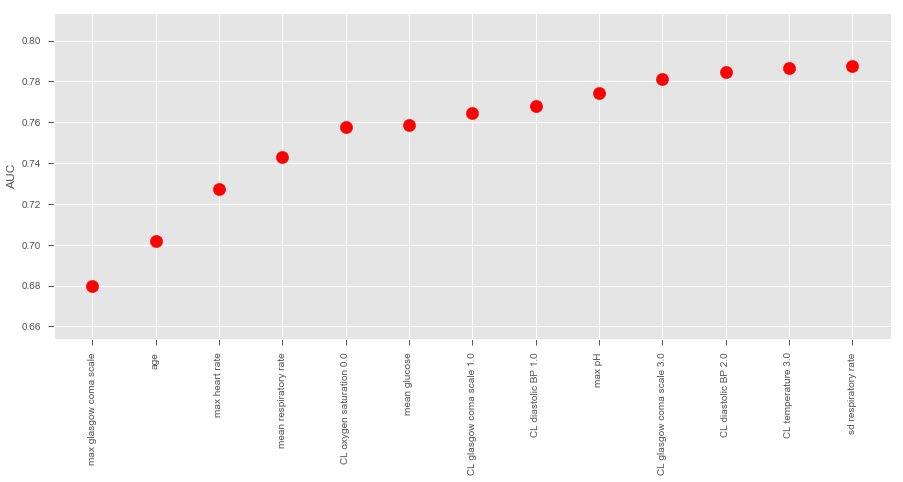

In [37]:
selected_features_sfs = ['max glasgow coma scale',
 'age',
 'max heart rate',
 'mean respiratory rate',
 'CL oxygen saturation 0.0',
 'mean glucose',
 'CL glasgow coma scale 1.0',
 'CL diastolic BP 1.0',
 'max pH',
 'CL glasgow coma scale 3.0',
 'CL diastolic BP 2.0',
 'CL temperature 3.0',
 'sd respiratory rate']

results_sfs = [0.6798755 , 0.70164518, 0.72723877, 0.74282496, 0.75746258,
       0.75842597, 0.76457981, 0.76804506, 0.7741989 , 0.78133096,
       0.78440788, 0.78652142, 0.78748481]

plt.figure(num=None, figsize=(15, 6))
plt.scatter(x = range(1,len(selected_features_sfs)+1,1), y = results_sfs, c = 'red', s = 150)
plt.xticks(range(1,len(selected_features_sfs)+1,1),selected_features_sfs, rotation = 'vertical')
plt.ylabel('AUC')
plt.show()

According to SFS, important features that help predict the outcome are:
        
* Maximum **GCS**, high increase in **GCS** during the first hours in the ICU (cluster 2) and slow decrease (cluster 4)

* **Age**

* Maximum **heart rate**

* Mean and variation in **respiratory rate**

* Distinguishing between low variation (cluster 2) and high variation (cluster 1 and 3) **oxygen saturation** 

* Mean **glucose** 

* Small increase in **diastolic BP** during the first 24 hours (cluster 2) and small decrease in the first 30 hours (cluster 3)

* Maximum **pH**

* Increase in **temperature** (cluster 4)

Exercise: investigate how these conclusions change when a different data partitioning is used for training and testing.

<img src="sfs.png">

#### b) Recursive Feature Elimination (RFE) 
Feature ranking with recursive feature elimination.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Define:

* **n_features_to_select**: number of features to select. If None, half of the features are selected.
Default=None

In [38]:
from sklearn.feature_selection import RFE

# n_features_to_select = np.floor(len(X_train.columns)/2)
n_features_to_select = 13

logreg = LogisticRegression(random_state = 1)
rfe = RFE(logreg, n_features_to_select)
rfe = rfe.fit(X_train_transf_clust_norm, y_train_transf_clust.values.ravel())

selected_features_rfe = X_train_transf_clust_norm.columns[rfe.support_]

print('Number of features selected: ' + str(len(X_train_transf_clust_norm.columns[rfe.support_])))
print()
print('Selected features:')
display.display( selected_features_rfe)
#print(rfe.ranking_)

Number of features selected: 13

Selected features:


Index(['min diastolic BP', 'min heart rate', 'min mean BP', 'max heart rate',
       'sd glasgow coma scale', 'sd oxygen saturation', 'sd temperature',
       'sd pH', 'mean glasgow coma scale', 'mean glucose',
       'mean respiratory rate', 'mean temperature', 'age'],
      dtype='object')

#### c) Features in common

In [39]:
selected_features_sfs_rfe = list(set(selected_features_rfe) & set(selected_features_sfs))
print('Number of features in common: ' + str(len(selected_features_sfs_rfe)))
display.display(selected_features_sfs_rfe)

Number of features in common: 4


['mean glucose', 'age', 'mean respiratory rate', 'max heart rate']

### 8.3.5. Modeling with selected features

We performed feature selection using the training set. Now, we are going to evaluate the performance of the model with the selected features in an independent test set not used before.

#### a) Sequential forward selection / forward stepwise selection

Threshold: 0.39
TP: 620
TN: 964
FP: 314
FN: 212
Accuracy: 0.75
Sensitivity: 0.75
Specificity: 0.75
AUC: 0.82


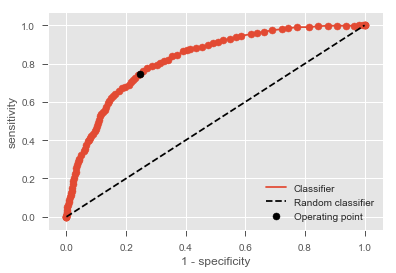

Threshold: 0.39
TP: 156
TN: 728
FP: 282
FN: 66
Accuracy: 0.72
Sensitivity: 0.7
Specificity: 0.72
AUC: 0.8


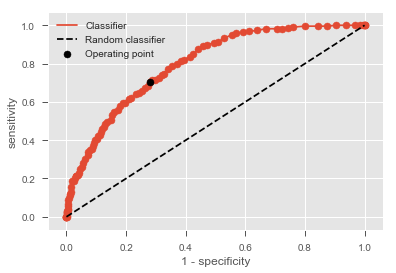

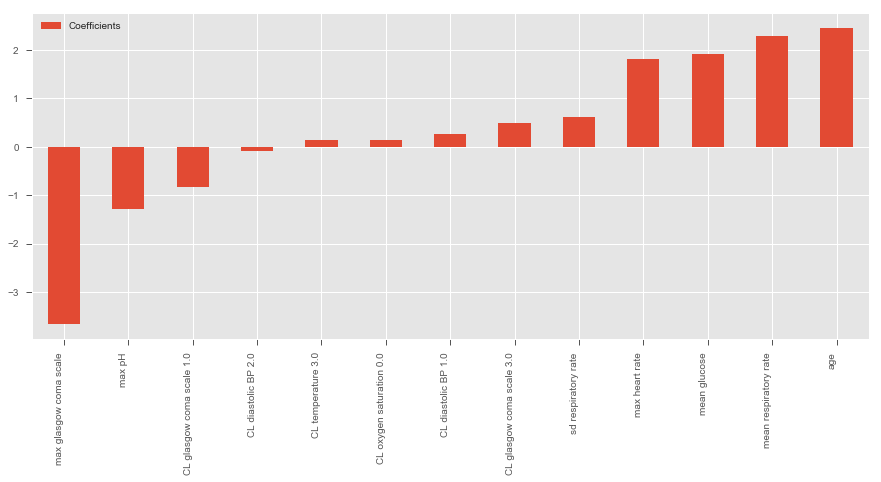

In [40]:
print_ = 1

model = LogisticRegression(random_state = 1)
model.fit(X_train_transf_clust_norm[selected_features_sfs], y_train_transf_clust.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(model, X_train_transf_clust_norm[selected_features_sfs], y_train_transf_clust, X_test_transf_clust_norm[selected_features_sfs], y_test_transf_clust, print_)
print_coef(model, X_train_transf_clust_norm[selected_features_sfs])

all_results_train['LR SFS'] = [AUC_train, sens_train, spec_train, len(selected_features_sfs)]
all_results_test['LR SFS'] = [AUC_test, sens_test, spec_test, len(selected_features_sfs)]



The results seem to cohere with expected clinical practice. There are enough variables in the model which correlate with mortality as we would expect them to. This increases our faith in the remainder of those variables whose association with mortality in clinical practice is not inherently obvious. The results evoke interesting relationships between other variables which are less well known to affect mortality, such as, for instance, mean glucose.

#### b) Recursive Feature Elimination (RFE)

Threshold: 0.4
TP: 638
TN: 982
FP: 296
FN: 194
Accuracy: 0.77
Sensitivity: 0.77
Specificity: 0.77
AUC: 0.85


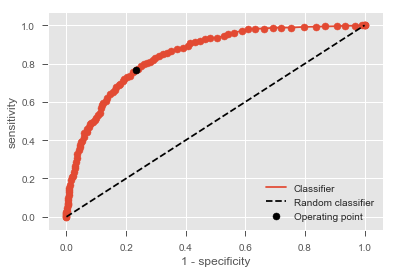

Threshold: 0.4
TP: 162
TN: 751
FP: 259
FN: 60
Accuracy: 0.74
Sensitivity: 0.73
Specificity: 0.74
AUC: 0.82


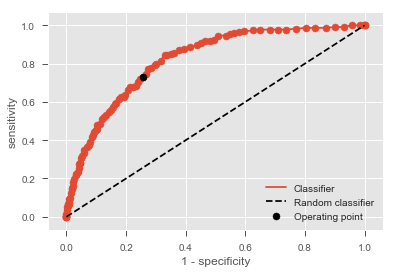

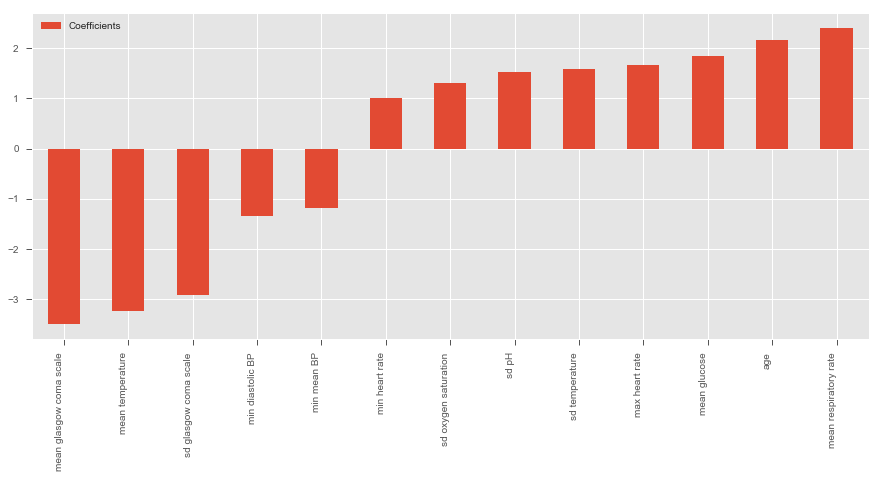

In [41]:
print_ = 1

model = LogisticRegression(random_state = 1)
model.fit(X_train_transf_clust_norm[selected_features_rfe], y_train_transf_clust.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(model, X_train_transf_clust_norm[selected_features_rfe], y_train_transf_clust, X_test_transf_clust_norm[selected_features_rfe], y_test_transf_clust, print_)
print_coef(model, X_train_transf_clust_norm[selected_features_rfe])

all_results_train['LR RFE'] = [AUC_train, sens_train, spec_train, len(selected_features_rfe)]
all_results_test['LR RFE'] = [AUC_test, sens_test, spec_test, len(selected_features_rfe)]


## 8.4. Decision tree

Most ICU severity scores are constructed using a logistic regression model, which imposes stringent constraints on the relationship between explanatory variables and outcome. In particular, logistic regression relies on the assumption of a linear and additive relationship between the outcome and its predictors. Given the complexity of the processes underlying death in ICU patients, this assumption might be unrealistic.

We hope to improve the prediction by using a nonparametritc algorithm such as a decision tree. Since this type of algorithms do not make strong assumptions about the form of the mapping function, they are good candidates when you have a lot of data and no prior knowledge, and when you don’t want to worry too much about choosing the right features.


### 8.4.1. CART algorithm 
https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/

* selecting input variables 
* selecting split points on those variables until a suitable tree is constructed

The selection of variables and the specific split is chosen using a greedy algorithm to minimize a cost function. Tree construction ends using a predefined stopping criterion, such as a minimum number of training instances assigned to each leaf node of the tree.

#### a) Greedy Splitting

* recursive binary splitting, a process of dividing up the input space

All input variables and all possible split points are evaluated and chosen in a greedy manner (the very best split point is chosen each time).

All values are lined up and different split points are tried and tested using a cost function. The split with the lowest cost is selected. 

For classification, the **Gini index** (G) function (also known as Gini impurity) is used which provides an indication of how "pure" the leaf nodes are. It gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. 

* **perfect class purity**: a node that has all classes of the same ($G=0$)
* **worst class purity**: a node that has a 50-50 split of classes ($G=0.5$)

The $G$ for each node is weighted by the total number of instances in the parent node. For a chosen split point in a binary classification problem, $G$ is calculated as:

$G = ((1 -g1_1^2 + g1_2^2) \times \frac{ng1}{n})+ ((1 - g2_1^2 + g2_2^2) \times \frac{ng2}{n})$

* $g1_1$: proportion of instances in group 1 for class 1
* $g1_2$: proportion of instances in group 1 for class 2
* $g2_1$: proportion of instances in group 2 for class 1
* $g2_2$: proportion of instances in group 2 for class 2
* $ng1$: total number of instances in group 1
* $ng2$: total number of instances in group 2 
* $n$: total number of instances we are trying to group from the parent node

#### b) Stopping Criterion

The most common stopping procedure is to use a minimum count on the number of training observations assigned to each leaf node. If the count is less than some minimum then the split is not accepted and the node is taken as a final leaf node.

The minimum count of training observations is tuned to the dataset. It defines how specific to the training data the tree will be. Too specific (e.g. a count of 1) and the tree will overfit the training data and likely have poor performance on the test set.

**DecisionTreeClassifier** from sklearn.ensemble

Here is a list of important parameters that we should have in consideration:

* **criterion**: function to measure the quality of a split.
Default="gini"

* **splitter**: strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.
Default="best"

* **max_features**: maximum number of features in each tree.
Default is sqrt(n_features)

* **max_depth**: maximum depth of the tree.
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.
Default=2

* **min_samples_leaf**: minimum number of samples required to be at a leaf node. 
Default=1

* **max_leaf_nodes**: grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
default=None

* **random_state**: if int, seed used by the random number generator.
Default=None

In the next script we are going to create a small decision tree (maximum depth = 5). You can investigate how the bias and variance are affected by different choices of parameters. Remember:

* **Bias**: How the algorithm performs on the training set.
* **Variance**: how much worse the algorithm does on the test set than the training set.

Threshold: 0.44
TP: 683
TN: 981
FP: 297
FN: 149
Accuracy: 0.79
Sensitivity: 0.82
Specificity: 0.77
AUC: 0.87


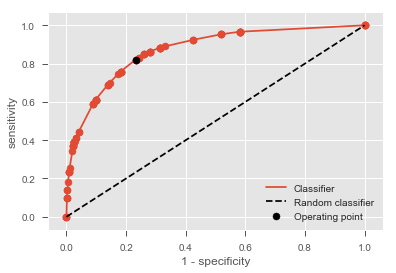

Threshold: 0.44
TP: 159
TN: 705
FP: 305
FN: 63
Accuracy: 0.7
Sensitivity: 0.72
Specificity: 0.7
AUC: 0.77


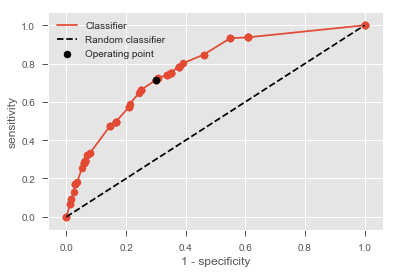

In [42]:
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

print_ = 1
clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_leaf = 20,
                                  min_samples_split = 20, random_state = 2, splitter = 'best')

clf_gini.fit(X_train_transf_clust, y_train_transf_clust)
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(clf_gini, X_train_transf_clust, y_train_transf_clust, X_test_transf_clust, y_test_transf_clust, print_)


### 8.4.2. Tree visualization

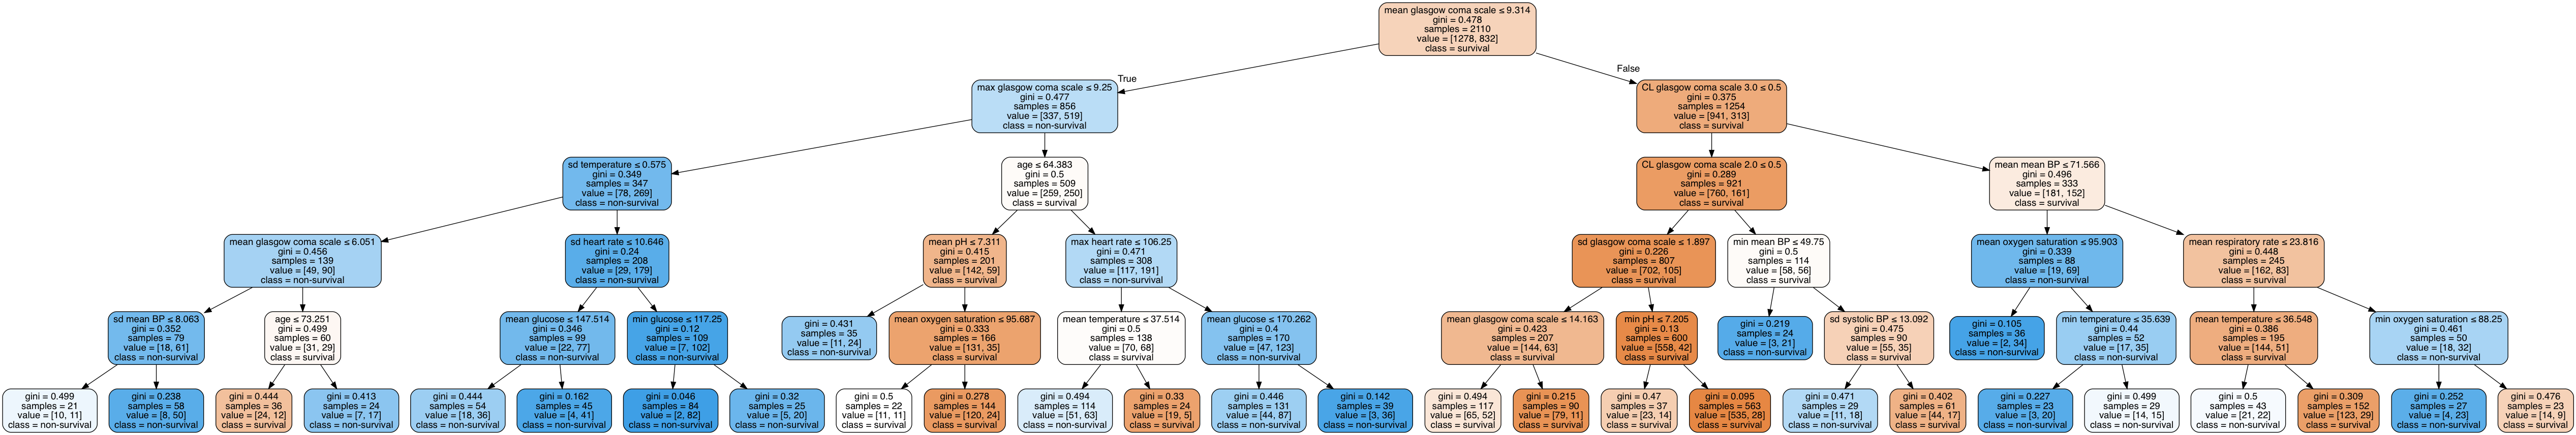

In [43]:
from sklearn.externals.six import StringIO  
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf_gini, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=["survival", "non-survival"],
                feature_names=X_train_transf_clust.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 8.4.3. Feature importance

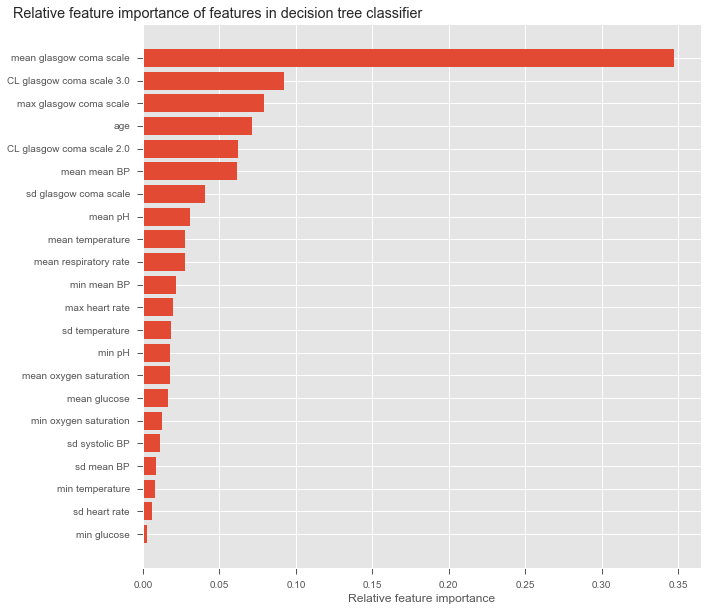

In [45]:
features = X_train_transf_clust.columns

list_feat = list(zip(features, clf_gini.feature_importances_))
# print(sorted(list_feat))
pd_list_feat = pd.DataFrame(list_feat)
pd_list_feat.columns = ('Feature','Importance')
pd_list_feat = pd_list_feat.sort_values(by='Importance')
                 
pd_list_top = pd_list_feat[pd_list_feat['Importance']>0]
plt.figure(figsize=(10,10))
plt.barh(range(len(pd_list_top)), pd_list_top['Importance'], align='center')
plt.yticks(range(len(pd_list_top)),pd_list_top['Feature'])
plt.title("Relative feature importance of features in decision tree classifier", ha = 'right')
plt.xlabel("Relative feature importance")
plt.show()

# the next script extracts the features selected by the DT
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    features = []
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            features.append(name)
            recurse(tree_.children_left[node], depth + 1)
            recurse(tree_.children_right[node], depth + 1)

    recurse(0, 1)
    return features

features_dt = tree_to_code(clf_gini, X_train_transf_clust.columns)

#display.display(features_dt)

all_results_train['DT'] = [AUC_train, sens_train, spec_train, len(features_dt)]
all_results_test['DT'] = [AUC_test, sens_test, spec_test, len(features_dt)]

## 8.5. Random forest

Random forest comprises split-variable selection and sub-sampling.

> "The essential idea in bagging is to average many noisy but approximately unbiased models, and hence reduce the variance. Trees are ideal candidates for bagging, since they can capture complex interaction structures in the data, and if grown sufficiently deep, have relatively low bias. Since trees are notoriously noisy, they benefit greatly from the averaging". Friedman et al. - 2008 - The Elements of Statistical Learning.
 
**Algorithm**. Random Forest for classification (training)

$B:$ Number of trees

1. For $b=1$ to $B$

    1.1. Draw a bootstrap sample of size $N_b$ from the training data.
    
    1.2. Grow a random tree $T_b$ to the bootstrapped data, by recursively repeating the following steps for each terminal node of the tree, until the minimum node size $n_{min}$ is reached. See **CART** algorithm.
        
    * Select *m* variables at random from the $p$ variables

    * Pick the best variable/split-point among $m$

    * Split the node into two daughter nodes
    

2. Output the ensemble of trees

**Algorithm**. Random Forest for classification (testing)

Let $C_b(x_i)$ be the predicted class probability of the $b$th tree in the ensemble for observation $x_i$. Then, the predicted class probability of the random forest for observation $x_i$ is: 

$C_{rf}^B(x_i)=  \frac{1}{B}\sum_{b=1}^{B}C_b(x_i)$

The predicted class probabilities of an input sample are computed as the mean predicted class probabilities of the trees in the forest. The class probability of a single tree is the fraction of samples of the same class in a leaf.

**RandomForestClassifier** from sklearn.ensemble

Parameters to define:

* **n_estimators**: number of trees in the forest.

* **criterion**: function to measure the quality of a split.
Default="gini"

* **max_features**: maximum number of features in each tree.
Default is sqrt(n_features)

* **max_depth**: maximum depth of the tree.
If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.
Default=2

* **min_samples_leaf**: minimum number of samples required to be at a leaf node (external node). 
Default=1

* **random_state**: if int, seed used by the random number generator.
Default=None

* **bootstrap**: Whether bootstrap samples are used when building trees. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True.
Default=True

Investigate how the bias and variance are affected by different choices of parameters. Remember:

* **Bias**: how the algorithm performs on the training set.
* **Variance**: how much worse the algorithm does on the test set than the training set.

Threshold: 0.4
TP: 819
TN: 1256
FP: 22
FN: 13
Accuracy: 0.98
Sensitivity: 0.98
Specificity: 0.98
AUC: 1.0


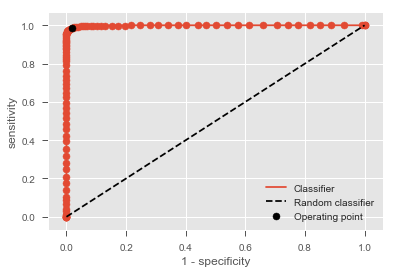

Threshold: 0.4
TP: 179
TN: 740
FP: 270
FN: 43
Accuracy: 0.75
Sensitivity: 0.81
Specificity: 0.73
AUC: 0.84


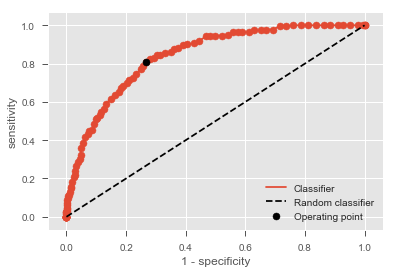

In [46]:
from sklearn.ensemble import RandomForestClassifier

print_ = 1
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, criterion = 'gini', 
                            max_depth = 10, random_state = 2)

rf.fit(X_train_transf_clust, y_train_transf_clust.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(rf, X_train_transf_clust, y_train_transf_clust, X_test_transf_clust, y_test_transf_clust, print_)

all_results_train['RF'] = [AUC_train, sens_train, spec_train, rf.n_features_]
all_results_test['RF'] = [AUC_test, sens_test, spec_test, rf.n_features_]


As you can see, in the previous RF configuration the training error is very low. This should lead you to suspect of/expect high variance. In fact, the performance in the test set is significantly lower. In order to reduce overfitting, we are going to reduce the depth of the trees and increase the min_samples_split.


Threshold: 0.41
TP: 681
TN: 1027
FP: 251
FN: 151
Accuracy: 0.81
Sensitivity: 0.82
Specificity: 0.8
AUC: 0.9


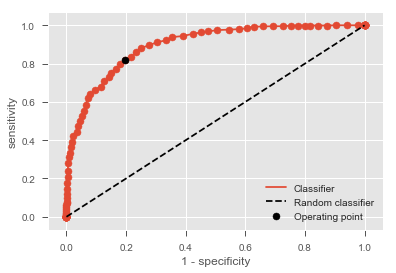

Threshold: 0.41
TP: 170
TN: 754
FP: 256
FN: 52
Accuracy: 0.75
Sensitivity: 0.77
Specificity: 0.75
AUC: 0.83


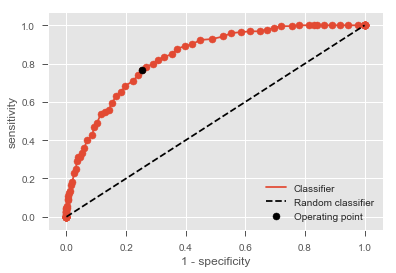

In [47]:
from sklearn.ensemble import RandomForestClassifier

print_ = 1
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, criterion = 'gini', 
                            max_depth = 4, min_samples_split = 30, random_state = 2)

rf.fit(X_train_transf_clust, y_train_transf_clust.values.ravel())
_, AUC_train, sens_train, spec_train, AUC_test, sens_test, spec_test = model_evaluation(rf, X_train_transf_clust, y_train_transf_clust, X_test_transf_clust, y_test_transf_clust, print_)

all_results_train['RF'] = [AUC_train, sens_train, spec_train, rf.n_features_]
all_results_test['RF'] = [AUC_test, sens_test, spec_test, rf.n_features_]


We were able to decrease the variance, but we still have moderate performance in the test set. Investigate whether increasing the maximum number of features in each tree improves the results.

The next script compares the above results with same RF without tuning the threshold.

In [48]:
from sklearn import metrics

y_pred_class_test = rf.predict(X_test_transf_clust)
fpr, tpr, thresholds = metrics.roc_curve(y_test_transf_clust, y_pred_class_test, pos_label=1)
auc = metrics.auc(fpr, tpr)
print('Sensitivity: ' + str(round(tpr[1],2)))
print('Specificity: ' + str(round(1-fpr[1],2)))
print('AUC: ' + str(round(auc,2)))

Sensitivity: 0.54
Specificity: 0.89
AUC: 0.71


Controlling the threshold allows us to achieve a better trade-off between sensitivity and specificity.

### 8.5.1. Feature importance

At each split in each tree, the improvement in the split-criterion ($G$) is the importance measure attributed to the splitting feature, and is accumulated over all the trees in the forest separately for each feature.

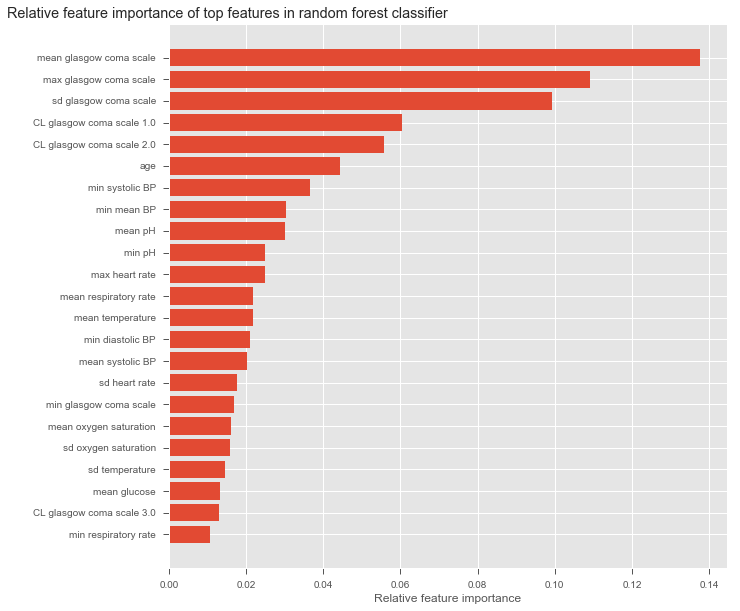

In [49]:
features = X_train_transf_clust.columns

#plt_x = np.linspace(0,len(features)-1,len(features))
#print("Features sorted by their score:")

list_feat = list(zip(features, rf.feature_importances_))
# print(sorted(list_feat))
pd_list_feat = pd.DataFrame(list_feat)
pd_list_feat.columns = ('Feature','Importance')
pd_list_feat = pd_list_feat.sort_values(by='Importance')
                 
pd_list_top = pd_list_feat[pd_list_feat['Importance']>0.01]
plt.figure(figsize=(10,10))
plt.barh(range(len(pd_list_top)), pd_list_top['Importance'], align='center')
plt.yticks(range(len(pd_list_top)),pd_list_top['Feature'])
plt.title("Relative feature importance of top features in random forest classifier", ha = 'right')
plt.xlabel("Relative feature importance")
plt.show()

The features to which RF assigns higher feature importance are consistent with previous findings. Several features extracted from glasgow coma scale appear at the top of feature relevancy but this does not mean that every tree is using all of them together.

# 9. Comparison of classifiers

The next script summarizes the performance of several classifiers and their ability to generalize.

In [50]:
print('Performance in training set')
display.display(np.round(all_results_train, decimals = 2))
print()

print('Performance in test set')
display.display(np.round(all_results_test, decimals = 2))
#all_results_test.loc[['AUC', 'Sensitivity','Specificity']].plot(kind = 'bar')
#plt.ylabel('Performance in test set')
#plt.show()
print()

print('Difference in performance (training-test)')
diff = np.round(all_results_train - all_results_test, decimals = 2)
display.display(diff)
# diff.loc[['AUC', 'Sensitivity','Specificity']].plot(kind = 'bar')
# plt.ylabel('Difference in performance')
# plt.xticks(rotation=None)
# plt.show()

Performance in training set


LR transf  LR cluster labels  LR transf + clust labels  LR SFS  \
AUC               0.85               0.74                      0.87    0.82   
Sensitivity       0.77               0.69                      0.79    0.75   
Specificity       0.77               0.69                      0.79    0.75   
# Features       42.00              43.00                     85.00   13.00   

             LR RFE     DT     RF  
AUC            0.85   0.87   0.90  
Sensitivity    0.77   0.82   0.82  
Specificity    0.77   0.77   0.80  
# Features    13.00  28.00  85.00


Performance in test set


LR transf  LR cluster labels  LR transf + clust labels  LR SFS  \
AUC               0.83               0.73                      0.84    0.80   
Sensitivity       0.75               0.68                      0.74    0.70   
Specificity       0.75               0.69                      0.77    0.72   
# Features       42.00              43.00                     85.00   13.00   

             LR RFE     DT     RF  
AUC            0.82   0.77   0.83  
Sensitivity    0.73   0.72   0.77  
Specificity    0.74   0.70   0.75  
# Features    13.00  28.00  85.00


Difference in performance (training-test)


LR transf  LR cluster labels  LR transf + clust labels  LR SFS  \
AUC               0.02               0.01                      0.03    0.02   
Sensitivity       0.02               0.01                      0.05    0.04   
Specificity       0.02               0.00                      0.03    0.03   
# Features        0.00               0.00                      0.00    0.00   

             LR RFE    DT    RF  
AUC            0.03  0.10  0.06  
Sensitivity    0.04  0.10  0.05  
Specificity    0.02  0.07  0.06  
# Features     0.00  0.00  0.00

* **Is the RF the best performer?**

Apparently not. It certainly performs well in the test set, but the increase in performance is not sufficient to be preferred over a simpler model.

* **Cluster labels are not enough**

They give very low performance when used alone, but are good when combined with other features.

* **What is the best model?**

At this point, it really is about selecting a good path to continue exploring. A single decision tree is clearly not the way to go in terms of performance, but it can be useful if interpretability is a must. LR is also interpretable when the feature set contains a resonable number of features. So if interpretability is important, LF with RFE or SFS should be considered (we should not choose RFE yet due to the issue presented next). In terms of interpretaibilty, RF and LR transf and LR transf + clust labels are a no go due to the high amount of features.

* **Cross validation**

Before making any conclusions about the performance, it is advisable to change the data partitions used for training and testing. Cross validation can be used to investigate the variablity in performance when different data partitions are used. Following this approach, all data is used for training and testing the models and the results are averaged over the rounds.

* **Model variance**

Decision tree based models have high variance, i.e., the trees are probably overfitting the training data and this hampers their ability to generalize. Again, cross-validation should be performed. We would probably get very different single DTs for different training partitions (which is why RF is better!).


# Exercises

## 1. 

We have performed dimensionality reduction by extracting relevant information from the time series and we have done this for the complete series (48h). Your job is to do this separately for each 24h and see if you are able to increase the performance. 
    
It is useful to evaluate the performance of the classifier using data from the first day. It will give us a more realistic sense of how the classifier would behave in a real setting if we wanted a decision at the end of the first day. Do you see a decrease in performance in this scenario?
    

## 2. 
We have performed clustering in order to stratify patients. We have normalized data for each patient individually so that the groups would reflect physiological time trends. 
    
2.1. What happens if you change the random seed used to generate the training and test sets? And if you change the random seed used to generate the initiate the cluster centers? Can you make the same observations about the patterns?
    
2.2. How do the patterns change if you don’t normalize data, or if you normalize data for the entire training set at once? 

# 3.

We have performed undersampling in order to mitigate bias toward a predominant class. Class balancing can also be performed by sampling an equal number of observations from each class. In sklearn, you can use the parameter class_weight in order to control for imbalanced training data when learning logistic regression, decision trees or random forest:

* class_weight = {class_label: weight}: weights associated with classes. If not given, all classes are supposed to have weight one.

* class_weight = "balanced": uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. It basically increases the weight of making an error with the under-represented class. 

Investigate how class_weight="balanced" impacts the performance of the models.

# 4.

Investigate how bias and variance are affected by different choices of parameters.